# Telco Customer Segmentation (Colab)
**Objective:** Use clustering (KMeans) to find actionable customer segments and recommend retention/monetization actions.  
**Dataset:** Telco Customer Churn (7k+ rows).  
**Tools:** Python, pandas, scikit-learn, seaborn, matplotlib.  
**Notebook sections:** Data load → Cleaning → Feature engineering → Scaling → K selection → KMeans → Profiling → Visualizations → Exports.


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Install optional packages (run only if missing)
!pip install --quiet openpyxl

# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import warnings
warnings.filterwarnings('ignore')

# Quick versions check
print("pandas:", pd.__version__)
print("numpy:", np.__version__)
print("matplotlib:", matplotlib.__version__)
print("seaborn:", sns.__version__)


pandas: 2.2.2
numpy: 2.0.2
matplotlib: 3.10.0
seaborn: 0.13.2


In [3]:
file_path = "/content/drive/MyDrive/Teleco-customer segmentation.xlsx"  # <-- update this
df = pd.read_excel(file_path)
print("Loaded dataset shape:", df.shape)
df.head(5)

Loaded dataset shape: (7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
# Basic info and missing values
print("Columns:", df.columns.tolist())
print("\nData types:\n", df.dtypes)
print("\nMissing values per column:\n", df.isnull().sum())

# A small numeric summary
display(df.describe(include=[np.number]).T)

# A quick display of unique values for categorical columns (first 10 columns for brevity)
cat_cols = df.select_dtypes(include=['object']).columns.tolist()
for c in cat_cols[:15]:
    print(f"\n--- Unique values for {c} ---")
    print(df[c].unique()[:20])

Columns: ['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn']

Data types:
 customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

Missing values per column:
 customerID          0


,count,mean,std,min,25%,50%,75%,max
SeniorCitizen,7043.0,0.162147,0.368612,0.00,0.0,0.00,0.00,1.00
tenure,7043.0,32.371149,24.559481,0.00,9.0,29.00,55.00,72.00
MonthlyCharges,7043.0,64.761692,30.090047,18.25,35.5,70.35,89.85,118.75



--- Unique values for customerID ---
['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' '7795-CFOCW' '9237-HQITU'
 '9305-CDSKC' '1452-KIOVK' '6713-OKOMC' '7892-POOKP' '6388-TABGU'
 '9763-GRSKD' '7469-LKBCI' '8091-TTVAX' '0280-XJGEX' '5129-JLPIS'
 '3655-SNQYZ' '8191-XWSZG' '9959-WOFKT' '4190-MFLUW' '4183-MYFRB']

--- Unique values for gender ---
['Female' 'Male']

--- Unique values for Partner ---
['Yes' 'No']

--- Unique values for Dependents ---
['No' 'Yes']

--- Unique values for PhoneService ---
['No' 'Yes']

--- Unique values for MultipleLines ---
['No phone service' 'No' 'Yes']

--- Unique values for InternetService ---
['DSL' 'Fiber optic' 'No']

--- Unique values for OnlineSecurity ---
['No' 'Yes' 'No internet service']

--- Unique values for OnlineBackup ---
['Yes' 'No' 'No internet service']

--- Unique values for DeviceProtection ---
['No' 'Yes' 'No internet service']

--- Unique values for TechSupport ---
['No' 'Yes' 'No internet service']

--- Unique values for StreamingTV ---
['No' 

In [5]:
### STEP 4 — DATA CLEANING ###

# Make a copy before cleaning
df_clean = df.copy()

# 1. Fix TotalCharges (convert from object to float)
df_clean['TotalCharges'] = pd.to_numeric(df_clean['TotalCharges'], errors='coerce')
df_clean['TotalCharges'] = df_clean['TotalCharges'].fillna(df_clean['TotalCharges'].median())

# 2. Convert SeniorCitizen from 0/1 to Yes/No
df_clean['SeniorCitizen'] = df_clean['SeniorCitizen'].replace({0: 'No', 1: 'Yes'})

# 3. Replace "No internet service" with "No" in service columns
service_cols = ['OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies']

for c in service_cols:
    df_clean[c] = df_clean[c].replace({'No internet service': 'No'})

# 4. Replace "No phone service" if present
if 'MultipleLines' in df_clean.columns:
    df_clean['MultipleLines'] = df_clean['MultipleLines'].replace({'No phone service': 'No'})

# 5. Strip whitespace from all string columns (important)
df_clean = df_clean.applymap(lambda x: x.strip() if isinstance(x, str) else x)

# 6. Drop CustomerID (not useful for clustering)
if 'customerID' in df_clean.columns:
    df_clean = df_clean.drop(columns=['customerID'])
if 'CustomerID' in df_clean.columns:
    df_clean = df_clean.drop(columns=['CustomerID'])

# 7. Check cleaning results
print("Cleaned dataset shape:", df_clean.shape)
print("\nMissing values after cleaning:\n", df_clean.isnull().sum())
df_clean.head(5)

Cleaned dataset shape: (7043, 20)

Missing values after cleaning:
 gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,No,Yes,No,1,No,No,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,No,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,No,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,No,No,No,45,No,No,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,No,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [6]:
### STEP 5 — FEATURE ENGINEERING ###

df_fe = df_clean.copy()

# 1. Number of services subscribed (Yes = 1)
service_cols = ['OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies']

df_fe['NumServices'] = df_fe[service_cols].apply(lambda row: (row == 'Yes').sum(), axis=1)

# 2. Average monthly revenue (TotalCharges / tenure)
# Avoid division by zero
df_fe['AvgMonthlyRevenue'] = df_fe.apply(
    lambda row: row['TotalCharges'] / row['tenure'] if row['tenure'] > 0 else 0, axis=1
)

# 3. Convert Contract column to numerical months
df_fe['ContractMonths'] = df_fe['Contract'].replace({
    'Month-to-month': 1,
    'One year': 12,
    'Two year': 24
})

# 4. High-value flag (1 if above median monthly charges)
median_charge = df_fe['MonthlyCharges'].median()
df_fe['HighValue'] = (df_fe['MonthlyCharges'] > median_charge).astype(int)

# Show results
df_fe[['NumServices', 'AvgMonthlyRevenue', 'ContractMonths', 'HighValue']].head(10)


,NumServices,AvgMonthlyRevenue,ContractMonths,HighValue
0,1,29.850000,1,0
1,2,55.573529,12,0
2,2,54.075000,1,0
3,3,40.905556,12,0
4,0,75.825000,1,1
5,3,102.562500,1,1
6,2,88.609091,1,1
7,1,30.190000,1,0
8,4,108.787500,1,1
9,2,56.257258,12,0


In [7]:
### FIXING ISSUES BEFORE SCALING ###

# Initialize df_model from df_fe
df_model = df_fe.copy()

# 1. Convert binary categorical columns to 0/1
binary_map = {'Yes': 1, 'No': 0, 'Female': 0, 'Male': 1}

# Identify all object columns that are binary (e.g., have 2 unique values)
# Exclude columns intended for OHE
ohe_candidates = ['InternetService', 'Contract', 'PaymentMethod']
cols_to_convert_to_binary = [
    col for col in df_model.select_dtypes(include='object').columns
    if df_model[col].nunique() <= 2 and col not in ohe_candidates
]

for col in cols_to_convert_to_binary:
    df_model[col] = df_model[col].map(binary_map)
    if df_model[col].isnull().any():
        print(f"Warning: NaN values introduced in column '{col}' after mapping. Original unique values: {df_fe[col].unique()}")


# 2. One-Hot Encode other categorical columns
df_model = pd.get_dummies(df_model, columns=ohe_candidates, drop_first=True)

# 3. Convert any remaining boolean columns to integers (True->1, False->0)
# (get_dummies usually creates uint8, but this is a safeguard)
df_model = df_model.replace({True:1, False:0})

# 4. Rebuild feature matrix X cleanly
# Select all numerical columns.
final_features = df_model.select_dtypes(include=[np.number]).columns.tolist()

# Exclude 'Churn' and 'HighValue' if they are not intended as features for clustering
if 'Churn' in final_features:
    final_features.remove('Churn')
if 'HighValue' in final_features:
    final_features.remove('HighValue')

X = df_model[final_features]

print("Final shape of X (fixed):", X.shape)
print("Columns in X:", X.columns.tolist())
X.head()

Final shape of X (fixed): (7043, 26)
Columns in X: ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'PaperlessBilling', 'MonthlyCharges', 'TotalCharges', 'NumServices', 'AvgMonthlyRevenue', 'ContractMonths', 'InternetService_Fiber optic', 'InternetService_No', 'Contract_One year', 'Contract_Two year', 'PaymentMethod_Credit card (automatic)', 'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check']


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,...,NumServices,AvgMonthlyRevenue,ContractMonths,InternetService_Fiber optic,InternetService_No,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,0,1,0,1,0,0,0,1,0,...,1,29.850000,1,0,0,0,0,0,1,0
1,1,0,0,0,34,1,0,1,0,1,...,2,55.573529,12,0,0,1,0,0,0,1
2,1,0,0,0,2,1,0,1,1,0,...,2,54.075000,1,0,0,0,0,0,0,1
3,1,0,0,0,45,0,0,1,0,1,...,3,40.905556,12,0,0,1,0,0,0,0
4,0,0,0,0,2,1,0,0,0,0,...,0,75.825000,1,1,0,0,0,0,1,0


In [8]:
### STEP 7 — SCALING THE FEATURES ###

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Scaled data shape:", X_scaled.shape)

# Convert back to DataFrame for easier debugging (optional)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)
X_scaled_df.head()


Scaled data shape: (7043, 26)


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,...,NumServices,AvgMonthlyRevenue,ContractMonths,InternetService_Fiber optic,InternetService_No,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,-1.009559,-0.439916,1.034530,-0.654012,-1.277445,-3.054010,-0.854176,-0.633933,1.378241,-0.723968,...,-0.561776,-1.151302,-0.820444,-0.885660,-0.525927,-0.514249,-0.562975,-0.525047,1.406418,-0.544807
1,0.990532,-0.439916,-0.966622,-0.654012,0.066327,0.327438,-0.854176,1.577454,-0.725563,1.381277,...,-0.020519,-0.301458,0.331296,-0.885660,-0.525927,1.944582,-0.562975,-0.525047,-0.711026,1.835513
2,0.990532,-0.439916,-0.966622,-0.654012,-1.236724,0.327438,-0.854176,1.577454,1.378241,-0.723968,...,-0.020519,-0.350966,-0.820444,-0.885660,-0.525927,-0.514249,-0.562975,-0.525047,-0.711026,1.835513
3,0.990532,-0.439916,-0.966622,-0.654012,0.514251,-3.054010,-0.854176,1.577454,-0.725563,1.381277,...,0.520738,-0.786053,0.331296,-0.885660,-0.525927,1.944582,-0.562975,-0.525047,-0.711026,-0.544807
4,-1.009559,-0.439916,-0.966622,-0.654012,-1.236724,0.327438,-0.854176,-0.633933,-0.725563,-0.723968,...,-1.103033,0.367602,-0.820444,1.129102,-0.525927,-0.514249,-0.562975,-0.525047,1.406418,-0.544807


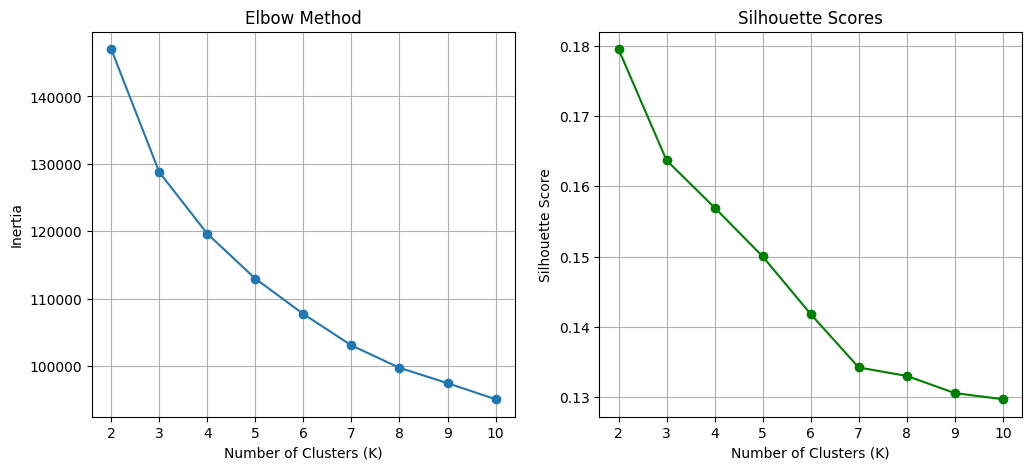

K=2: Inertia=147001.22, Silhouette=0.1795
K=3: Inertia=128770.83, Silhouette=0.1637
K=4: Inertia=119653.38, Silhouette=0.1570
K=5: Inertia=112991.12, Silhouette=0.1500
K=6: Inertia=107752.79, Silhouette=0.1418
K=7: Inertia=103099.45, Silhouette=0.1342
K=8: Inertia=99776.94, Silhouette=0.1330
K=9: Inertia=97504.23, Silhouette=0.1306
K=10: Inertia=95121.01, Silhouette=0.1297


In [9]:
### STEP 8 — FINDING THE OPTIMAL NUMBER OF CLUSTERS ###

inertia_list = []
silhouette_list = []

K_range = range(2, 11)   # Try K between 2 and 10

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)

    inertia_list.append(kmeans.inertia_)  # For elbow method

    # Silhouette score only works if k < number of samples
    labels = kmeans.labels_
    sil_score = silhouette_score(X_scaled, labels)
    silhouette_list.append(sil_score)

# -------------------------
# Plot 1 — Elbow Curve
# -------------------------
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(K_range, inertia_list, marker='o')
plt.title("Elbow Method")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Inertia")
plt.grid(True)

# -------------------------
# Plot 2 — Silhouette Score
# -------------------------
plt.subplot(1,2,2)
plt.plot(K_range, silhouette_list, marker='o', color='green')
plt.title("Silhouette Scores")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Silhouette Score")
plt.grid(True)

plt.show()

# Print numeric values
for k, inert, sil in zip(K_range, inertia_list, silhouette_list):
    print(f"K={k}: Inertia={inert:.2f}, Silhouette={sil:.4f}")


In [10]:
### STEP 9 — FINAL KMEANS MODEL (K = 3) ###

from sklearn.cluster import KMeans

k = 3

kmeans_final = KMeans(n_clusters=k, random_state=42, n_init=10)
cluster_labels = kmeans_final.fit_predict(X_scaled)

# Add cluster labels to the original df
df_fe['Cluster'] = cluster_labels

print("Cluster counts:")
print(df_fe['Cluster'].value_counts())
df_fe.head()


Cluster counts:
Cluster
2    2938
0    2188
1    1917
Name: count, dtype: int64


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,...,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,NumServices,AvgMonthlyRevenue,ContractMonths,HighValue,Cluster
0,Female,No,Yes,No,1,No,No,DSL,No,Yes,...,Yes,Electronic check,29.85,29.85,No,1,29.850000,1,0,2
1,Male,No,No,No,34,Yes,No,DSL,Yes,No,...,No,Mailed check,56.95,1889.50,No,2,55.573529,12,0,1
2,Male,No,No,No,2,Yes,No,DSL,Yes,Yes,...,Yes,Mailed check,53.85,108.15,Yes,2,54.075000,1,0,2
3,Male,No,No,No,45,No,No,DSL,Yes,No,...,No,Bank transfer (automatic),42.30,1840.75,No,3,40.905556,12,0,0
4,Female,No,No,No,2,Yes,No,Fiber optic,No,No,...,Yes,Electronic check,70.70,151.65,Yes,0,75.825000,1,1,2


In [11]:
### STEP 10 — CLUSTER PROFILING ###

import pandas as pd

# 1. Compute numerical means
cluster_profile_numeric = df_fe.groupby('Cluster')[[
    'MonthlyCharges','TotalCharges','tenure','NumServices',
    'AvgMonthlyRevenue','ContractMonths'
]].mean()

print("NUMERIC PROFILE:")
print(cluster_profile_numeric)
print("\n" + "="*60 + "\n")

# 2. Compute categorical distributions
categorical_cols = ['gender','SeniorCitizen','Partner','Dependents',
                    'InternetService','Contract','PaymentMethod','Churn']

cluster_profile_categorical = {}

for col in categorical_cols:
    cluster_profile_categorical[col] = (
        df_fe.groupby('Cluster')[col]
        .value_counts(normalize=True)
        .rename("percentage")
        .mul(100)
        .round(1)
    )

# Print each categorical distribution
for col, dist in cluster_profile_categorical.items():
    print(f"CATEGORICAL DISTRIBUTION — {col.upper()}:")
    print(dist)
    print("\n" + "-"*50 + "\n")

NUMERIC PROFILE:
         MonthlyCharges  TotalCharges     tenure  NumServices  \
Cluster                                                         
0             87.932952   4975.038665  56.069013     4.157678   
1             25.143375    697.627843  28.225352     0.191967   
2             73.355837   1310.008084  17.427842     1.663717   

         AvgMonthlyRevenue  ContractMonths  
Cluster                                     
0                87.846856       15.784278  
1                25.095231       11.851852  
2                73.299206        1.693329  


CATEGORICAL DISTRIBUTION — GENDER:
Cluster  gender
0        Female    50.2
         Male      49.8
1        Male      51.4
         Female    48.6
2        Male      50.4
         Female    49.6
Name: percentage, dtype: float64

--------------------------------------------------

CATEGORICAL DISTRIBUTION — SENIORCITIZEN:
Cluster  SeniorCitizen
0        No               83.5
         Yes              16.5
1        No           

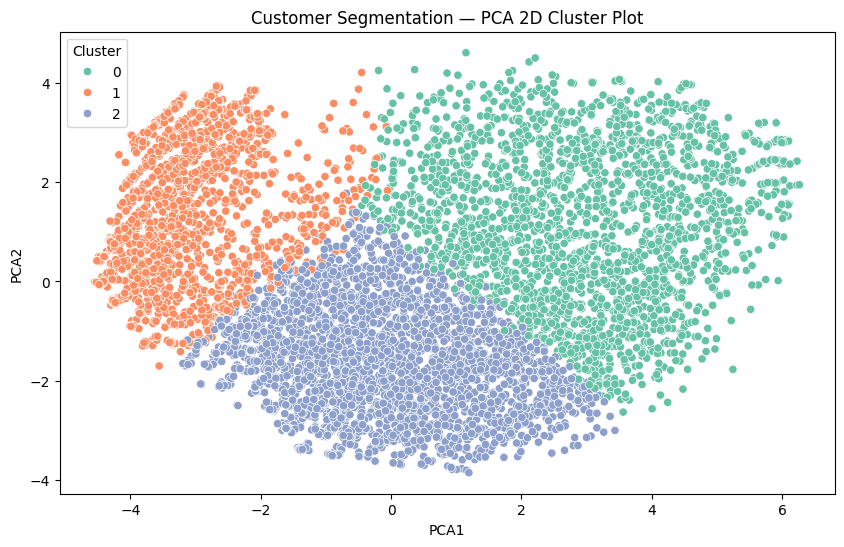

In [12]:
### STEP 11 — PCA VISUALIZATION ###

from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_scaled)

df_fe['PCA1'] = pca_result[:,0]
df_fe['PCA2'] = pca_result[:,1]

plt.figure(figsize=(10,6))
sns.scatterplot(data=df_fe, x='PCA1', y='PCA2', hue='Cluster', palette='Set2')
plt.title("Customer Segmentation — PCA 2D Cluster Plot")
plt.show()

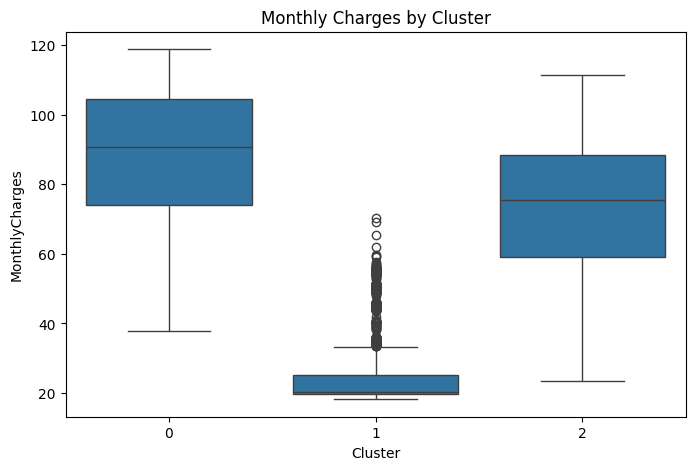

In [13]:
plt.figure(figsize=(8,5))
sns.boxplot(data=df_fe, x='Cluster', y='MonthlyCharges')
plt.title("Monthly Charges by Cluster")
plt.show()


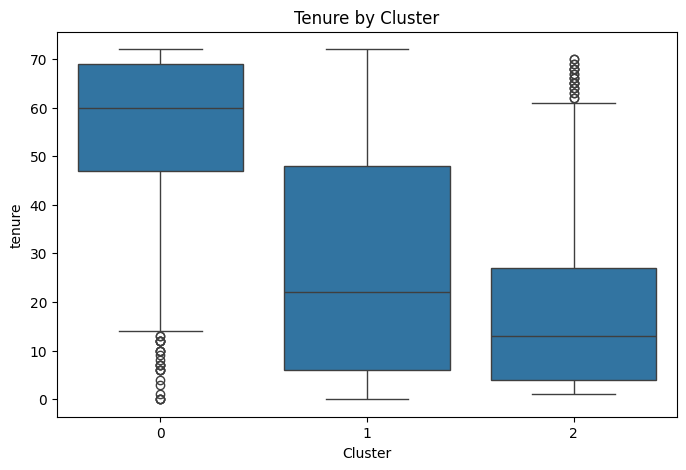

In [14]:
plt.figure(figsize=(8,5))
sns.boxplot(data=df_fe, x='Cluster', y='tenure')
plt.title("Tenure by Cluster")
plt.show()


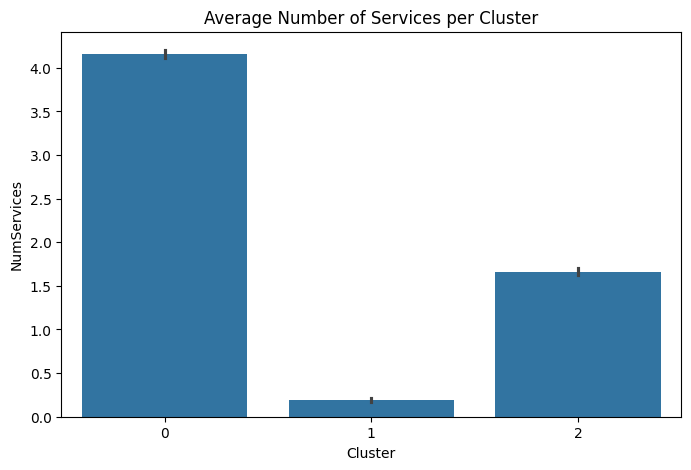

In [15]:
plt.figure(figsize=(8,5))
sns.barplot(data=df_fe, x='Cluster', y='NumServices', estimator='mean')
plt.title("Average Number of Services per Cluster")
plt.show()


In [16]:
# Helpers: cleaning and feature-engineering functions
def clean_total_charges(df):
    df = df.copy()
    df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
    df['TotalCharges'] = df['TotalCharges'].fillna(df['TotalCharges'].median())
    # strip whitespace
    df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)
    # restore SeniorCitizen numeric semantics if needed
    if 'SeniorCitizen' in df.columns:
        df['SeniorCitizen'] = df['SeniorCitizen'].replace({0:'No', 1:'Yes'}) if df['SeniorCitizen'].dtype != 'object' else df['SeniorCitizen']
    return df

def feature_engineer(df):
    df = df.copy()
    # fix internet-service related strings
    svc = ['OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies']
    for c in svc:
        if c in df.columns:
            df[c] = df[c].replace({'No internet service':'No'})
    # NumServices
    df['NumServices'] = df[[c for c in svc if c in df.columns]].apply(lambda r: (r=='Yes').sum(), axis=1)
    # AvgMonthlyRevenue
    df['AvgMonthlyRevenue'] = df.apply(lambda r: r['TotalCharges']/r['tenure'] if r['tenure']>0 else r['TotalCharges'], axis=1)
    # ContractMonths
    if 'Contract' in df.columns:
        df['ContractMonths'] = df['Contract'].replace({'Month-to-month':1,'One year':12,'Two year':24})
    # HighValue flag
    if 'MonthlyCharges' in df.columns:
        df['HighValue'] = (df['MonthlyCharges'] > df['MonthlyCharges'].median()).astype(int)
    return df

def build_feature_matrix(df):
    dfm = df.copy()
    # restore and encode gender robustly
    if 'gender' in dfm.columns:
        dfm['gender'] = dfm['gender'].map({'Male':1,'Female':0}).fillna(0).astype(int)
    # map Yes/No -> 1/0 for candidate binaries
    binaries = ['OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies','PaperlessBilling','Partner','Dependents','SeniorCitizen']
    for b in binaries:
        if b in dfm.columns:
            dfm[b] = dfm[b].map({'Yes':1,'No':0,1:1,0:0}).fillna(0).astype(int)
    # One-hot multi categories
    ohe_cols = [c for c in ['InternetService','Contract','PaymentMethod'] if c in dfm.columns]
    dfm = pd.get_dummies(dfm, columns=ohe_cols, drop_first=True)
    final_features = [
        'tenure','MonthlyCharges','TotalCharges','AvgMonthlyRevenue','NumServices','ContractMonths',
        'OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies',
        'PaperlessBilling','Partner','Dependents','gender','SeniorCitizen'
    ]
    # add any ohe columns
    final_features += [c for c in dfm.columns if any(prefix in c for prefix in ['InternetService_','Contract_','PaymentMethod_'])]
    final_features = [c for c in final_features if c in dfm.columns]
    X = dfm[final_features].copy()
    return X, dfm


In [17]:
# Cluster stability: run KMeans multiple times and compute adjusted rand index (ARI) between runs
from sklearn.metrics import adjusted_rand_score

def kmeans_stability(X_scaled, k=3, runs=10):
    labels_runs = []
    for i in range(runs):
        kmeans = KMeans(n_clusters=k, random_state=42+i, n_init=10).fit(X_scaled)
        labels_runs.append(kmeans.labels_)
    # pairwise ARI
    import itertools
    aris = []
    for a,b in itertools.combinations(range(runs),2):
        aris.append(adjusted_rand_score(labels_runs[a], labels_runs[b]))
    return {'mean_ari': np.mean(aris), 'median_ari': np.median(aris), 'min_ari': np.min(aris)}

# Example usage after you have X_scaled:
# stability = kmeans_stability(X_scaled, k=3, runs=8)
# print(stability)


In [18]:
# After kmeans_final is fit and you have X columns
centroids = pd.DataFrame(kmeans_final.cluster_centers_, columns=X.columns)
# centroid in original scale (if you saved scaler)
# If you have scaler: inverse_transform; else this shows scaled centroids
display(centroids.T.sort_values(by=0, ascending=False).head(10))  # top features for cluster 0
# Show top 5 features per cluster (absolute difference from overall mean)
overall_mean = X_scaled_df.mean()
for i in range(centroids.shape[0]):
    diffs = (centroids.loc[i] - overall_mean).abs().sort_values(ascending=False)
    print(f"Cluster {i} top features (scaled diff):")
    print(diffs.head(8))
    print("---")


,0,1,2
TotalCharges,1.188959,-0.699432,-0.429078
NumServices,1.147340,-0.999130,-0.202535
tenure,0.964986,-0.168818,-0.608497
DeviceProtection,0.828987,-0.666861,-0.182250
MonthlyCharges,0.770119,-1.316752,0.285634
TechSupport,0.768344,-0.522205,-0.231474
AvgMonthlyRevenue,0.764776,-1.308389,0.284156
OnlineBackup,0.744600,-0.648742,-0.131228
ContractMonths,0.727524,0.315785,-0.747850
StreamingTV,0.726308,-0.778336,-0.033047


Cluster 0 top features (scaled diff):
TotalCharges         1.188959
NumServices          1.147340
tenure               0.964986
DeviceProtection     0.828987
MonthlyCharges       0.770119
TechSupport          0.768344
AvgMonthlyRevenue    0.764776
OnlineBackup         0.744600
dtype: float64
---
Cluster 1 top features (scaled diff):
InternetService_No             1.406314
MonthlyCharges                 1.316752
AvgMonthlyRevenue              1.308389
NumServices                    0.999130
InternetService_Fiber optic    0.883558
StreamingMovies                0.785365
StreamingTV                    0.778336
TotalCharges                   0.699432
dtype: float64
---
Cluster 2 top features (scaled diff):
ContractMonths                    0.747850
tenure                            0.608497
Contract_Two year                 0.561383
InternetService_No                0.525927
PaymentMethod_Electronic check    0.519225
TotalCharges                      0.429078
InternetService_Fiber optic   

In [19]:
# STEP 5 — Per-cluster churn rate and revenue analysis (FIXED)

# Use df_fe because it contains cluster labels and all engineered features
summary = df_fe.copy()

# Make sure the column names are correct
# Replace string churn values with binary if needed
if summary['Churn'].dtype == 'object':
    summary['Churn'] = summary['Churn'].map({'Yes':1, 'No':0})

# Validate CustomerID column (if missing, use index)
summary['CustomerID'] = summary.index

cluster_summary = summary.groupby('Cluster').agg(
    customers=('CustomerID', 'count'),
    churn_rate=('Churn', 'mean'),
    avg_monthly=('MonthlyCharges', 'mean'),
    avg_tenure=('tenure', 'mean')
)

# Calculate total monthly


In [20]:
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

def compare_cluster_methods(X_scaled, k=3):
    results = {}
    # KMeans
    km = KMeans(n_clusters=k, random_state=42, n_init=10).fit(X_scaled)
    results['KMeans'] = silhouette_score(X_scaled, km.labels_)
    # GMM
    gmm = GaussianMixture(n_components=k, random_state=42).fit(X_scaled)
    gmm_labels = gmm.predict(X_scaled)
    results['GMM'] = silhouette_score(X_scaled, gmm_labels)
    # Agglomerative
    agg = AgglomerativeClustering(n_clusters=k).fit(X_scaled)
    results['Agglomerative'] = silhouette_score(X_scaled, agg.labels_)
    return results

# Example usage:
# compare_results = compare_cluster_methods(X_scaled, k=3)
# print(compare_results)


Cluster
0    0.119266
1    0.244526
2    0.144015
Name: silhouette, dtype: float64


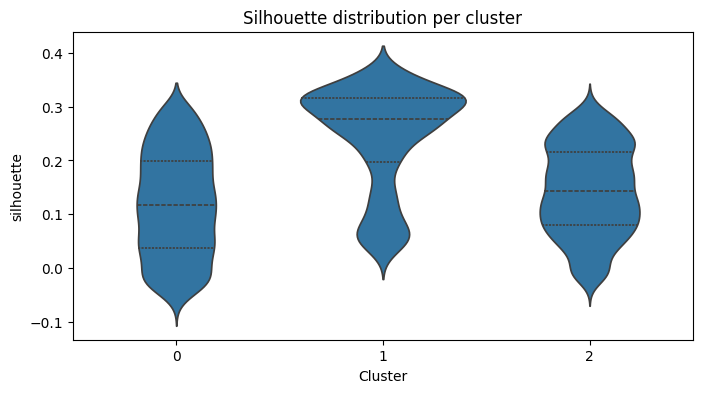

In [21]:
from sklearn.metrics import silhouette_samples
# compute sample-wise silhouette
sample_silhouette_values = silhouette_samples(X_scaled, cluster_labels)
df_fe['silhouette'] = sample_silhouette_values
# mean silhouette per cluster
print(df_fe.groupby('Cluster')['silhouette'].mean())
# silhouette distribution plot
plt.figure(figsize=(8,4))
sns.violinplot(x='Cluster', y='silhouette', data=df_fe, inner='quartile')
plt.title('Silhouette distribution per cluster')
plt.show()


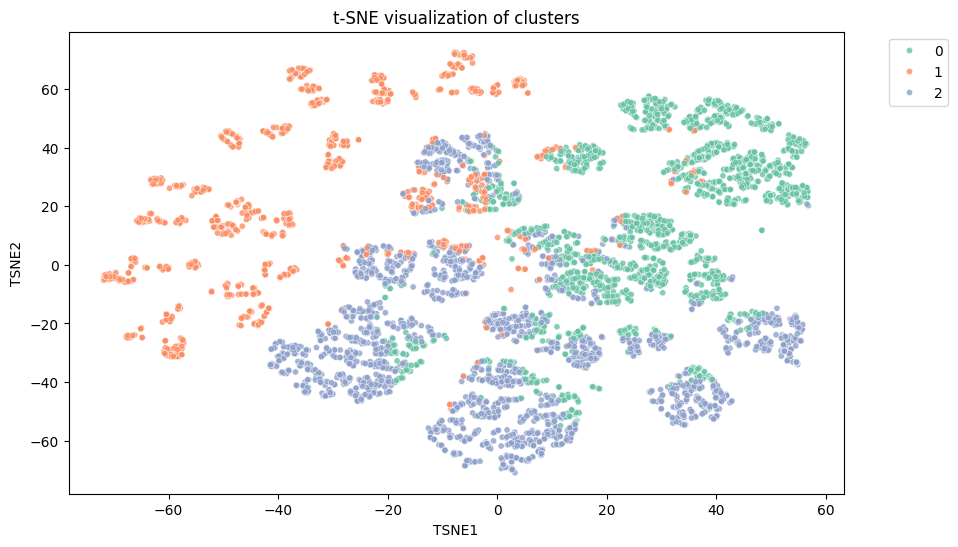

In [22]:
# PCA + t-SNE plot (t-SNE optional for heavy compute)
from sklearn.manifold import TSNE
pca = PCA(n_components=10, random_state=42).fit_transform(X_scaled)
tsne = TSNE(n_components=2, random_state=42, perplexity=40, n_iter=800).fit_transform(pca)
df_fe['TSNE1'] = tsne[:,0]; df_fe['TSNE2'] = tsne[:,1]

plt.figure(figsize=(10,6))
sns.scatterplot(x='TSNE1', y='TSNE2', hue='Cluster', data=df_fe, palette='Set2', s=20, alpha=0.8)
plt.title('t-SNE visualization of clusters')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
plt.show()


In [23]:
# Automated persona generator
def generate_persona(df, cluster_label):
    row = df[df['Cluster']==cluster_label]
    m = row['MonthlyCharges'].mean()
    t = row['tenure'].median()
    nsvc = row['NumServices'].mean()
    churn = (row['Churn']=='Yes').mean() * 100
    contract_mode = row['Contract'].mode().iloc[0]
    persona = f"Cluster {cluster_label}: AvgCharges ₹{m:.0f}, MedianTenure {t:.0f} months, AvgServices {nsvc:.1f}, Churn {churn:.1f}%. Dominant contract: {contract_mode}."
    return persona

for c in sorted(df_fe['Cluster'].unique()):
    print(generate_persona(df_fe, c))


Cluster 0: AvgCharges ₹88, MedianTenure 60 months, AvgServices 4.2, Churn 12.5%. Dominant contract: Two year.
Cluster 1: AvgCharges ₹25, MedianTenure 22 months, AvgServices 0.2, Churn 10.4%. Dominant contract: Month-to-month.
Cluster 2: AvgCharges ₹73, MedianTenure 13 months, AvgServices 1.7, Churn 47.5%. Dominant contract: Month-to-month.


In [24]:
# Export cluster labels with key features
df_export = df_fe.copy()
df_export.to_csv('telco_clusters_with_features.csv', index=False)
# Save KMeans model and scaler
import joblib
joblib.dump(kmeans_final, 'kmeans_telco_model.joblib')
joblib.dump(scaler, 'scaler_telco.joblib')
print("Exported CSV and models")


Exported CSV and models


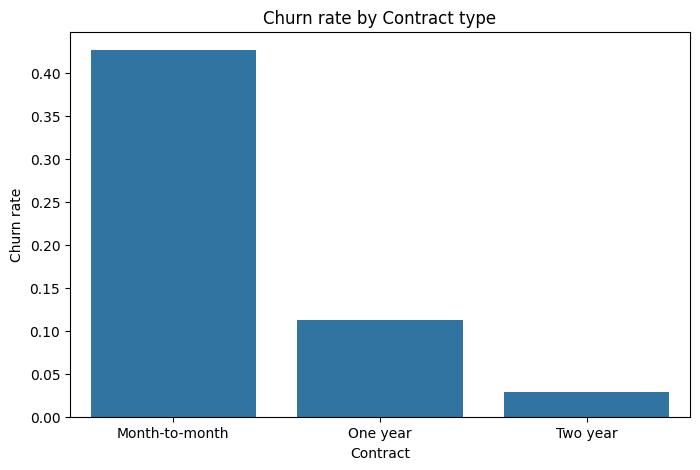

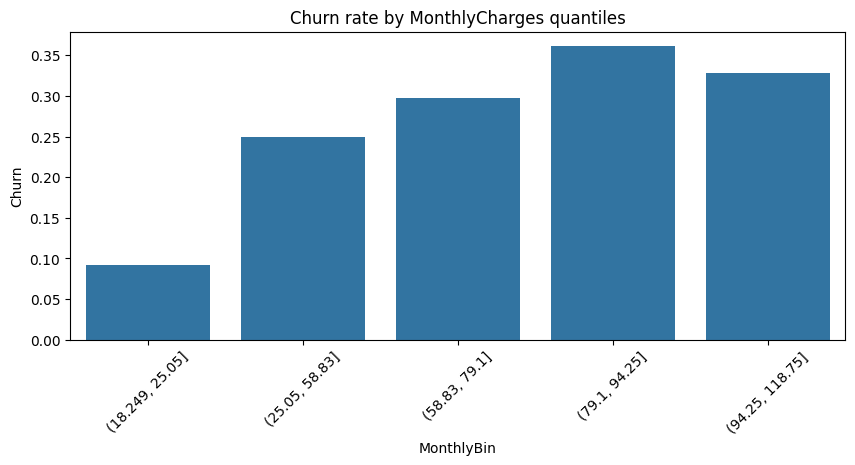

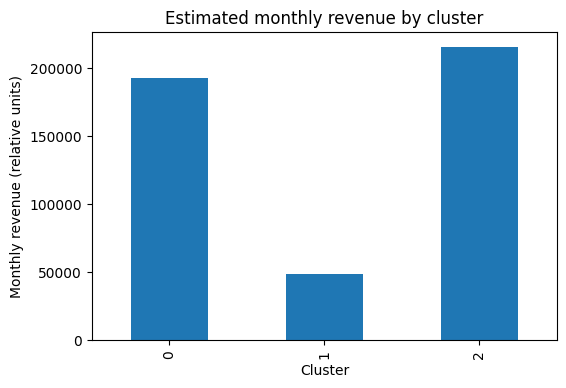

In [25]:
# G. Additional business visuals

# 1. Churn by Contract type (full df_fe)
plt.figure(figsize=(8,5))
contract_churn = df_fe.groupby('Contract')['Churn'].apply(lambda s: (s=='Yes').mean()).reset_index()
contract_churn.columns = ['Contract','churn_rate']
sns.barplot(data=contract_churn, x='Contract', y='churn_rate')
plt.title('Churn rate by Contract type'); plt.ylabel('Churn rate'); plt.show()

# 2. Churn by MonthlyCharges bins
df_fe['MonthlyBin'] = pd.qcut(df_fe['MonthlyCharges'], 5)
mb = df_fe.groupby('MonthlyBin')['Churn'].apply(lambda s: (s=='Yes').mean()).reset_index()
plt.figure(figsize=(10,4))
sns.barplot(data=mb, x='MonthlyBin', y='Churn')
plt.xticks(rotation=45); plt.title('Churn rate by MonthlyCharges quantiles'); plt.show()

# 3. Revenue per cluster (avg monthly * customers)
cluster_counts = df_fe.groupby('Cluster').size()
cluster_avg_month = df_fe.groupby('Cluster')['MonthlyCharges'].mean()
cluster_revenue = cluster_counts * cluster_avg_month
plt.figure(figsize=(6,4))
cluster_revenue.plot(kind='bar')
plt.title('Estimated monthly revenue by cluster'); plt.ylabel('Monthly revenue (relative units)'); plt.show()


In [26]:
# H. Automated Personas with recommended actions

def persona_and_actions(df, cluster_label):
    grp = df[df['Cluster']==cluster_label]
    n = len(grp)
    churn = (grp['Churn']=='Yes').mean()*100
    avg_charges = grp['MonthlyCharges'].mean()
    avg_tenure = grp['tenure'].median()
    services = grp['NumServices'].mean()
    contract_top = grp['Contract'].mode().iloc[0]
    internet_top = grp['InternetService'].mode().iloc[0]

    # Persona description
    persona = f"Cluster {cluster_label} — {n} customers | Median tenure {avg_tenure:.0f} months | Avg monthly ₹{avg_charges:.0f} | Services {services:.1f} | Dominant contract: {contract_top} | Dominant internet: {internet_top} | Churn: {churn:.1f}%."

    # Recommended actions (sample)
    actions = []
    if churn > 0.25:
        actions.append("Targeted retention offers (discounts, 1-yr lock-in)")
        actions.append("Personalized onboarding & support for early tenure customers")
    else:
        actions.append("Upsell premium bundles and multi-year discounts")

    if services < 1:
        actions.append("Bundle inexpensive internet add-ons to increase ARPU")
    else:
        actions.append("Protect loyalty through rewards & priority support")

    kpis = {
        'target': "reduce churn by 5% in 6 months",
        'impact_estimate': f"≈{int(n * avg_charges * 0.05)} monthly revenue retained if churn reduces by 5%"
    }
    return persona, actions, kpis

for c in sorted(df_fe['Cluster'].unique()):
    p, acts, kpis = persona_and_actions(df_fe, c)
    print(p)
    print("Suggested actions:", "; ".join(acts))
    print("KPIs & impact:", kpis)
    print("-"*80)


Cluster 0 — 2188 customers | Median tenure 60 months | Avg monthly ₹88 | Services 4.2 | Dominant contract: Two year | Dominant internet: Fiber optic | Churn: 12.5%.
Suggested actions: Targeted retention offers (discounts, 1-yr lock-in); Personalized onboarding & support for early tenure customers; Protect loyalty through rewards & priority support
KPIs & impact: {'target': 'reduce churn by 5% in 6 months', 'impact_estimate': '≈9619 monthly revenue retained if churn reduces by 5%'}
--------------------------------------------------------------------------------
Cluster 1 — 1917 customers | Median tenure 22 months | Avg monthly ₹25 | Services 0.2 | Dominant contract: Month-to-month | Dominant internet: No | Churn: 10.4%.
Suggested actions: Targeted retention offers (discounts, 1-yr lock-in); Personalized onboarding & support for early tenure customers; Bundle inexpensive internet add-ons to increase ARPU
KPIs & impact: {'target': 'reduce churn by 5% in 6 months', 'impact_estimate': '≈240

In [27]:
# === Cell 1: Build robust churn feature set & train/test split ===
import numpy as np, pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Defensive checks
assert 'df_fe' in globals(), "df_fe not found. Make sure your feature-engineered dataframe is named df_fe."
assert 'X' in globals(), "X (numeric feature matrix for clustering) not found. Ensure X exists."

# Start with the numeric features already prepared for clustering (X)
X_churn = X.copy()

# Add the 'Cluster' column as a feature for the churn model, if it exists
if 'Cluster' in df_fe.columns:
    X_churn['Cluster'] = df_fe['Cluster'].copy()

# Prepare the target variable 'y_churn'
y_churn = df_fe['Churn'].copy()
if y_churn.dtype == 'object':
    y_churn = y_churn.map({'Yes':1, 'No':0})
y_churn = y_churn.fillna(0).astype(int)

# --- Robustly ensure all features in X_churn are numeric ---
# This step attempts to convert all columns to numeric, coercing any non-convertible values to NaN.
# Then, it fills those NaNs (if any) and performs a final check.
for col in X_churn.columns:
    # Attempt to convert to numeric, coercing errors to NaN
    X_churn[col] = pd.to_numeric(X_churn[col], errors='coerce')
    # Fill any NaNs that resulted from coercion (e.g., if a truly non-numeric value was found)
    if X_churn[col].isnull().any():
        print(f"Warning: Column '{col}' had non-numeric values converted to NaN and filled. "
              "This indicates unexpected data types in the feature matrix.")
        if pd.api.types.is_numeric_dtype(X_churn[col]): # Check again after pd.to_numeric
            X_churn[col] = X_churn[col].fillna(X_churn[col].median())
        else:
            # Fallback for extreme cases, though pd.to_numeric should prevent this if not mixed types
            X_churn[col] = X_churn[col].fillna(X_churn[col].mode().iloc[0])
    # Final check: if still not numeric, raise a critical error
    if not pd.api.types.is_numeric_dtype(X_churn[col]):
        raise TypeError(f"Critical Error: Column '{col}' in X_churn remains non-numeric after robust conversion attempts.")


# Train-test split (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X_churn, y_churn, test_size=0.25, random_state=42, stratify=y_churn
)

# Standardize ALL features (since X_churn is now guaranteed to be fully numeric)
churn_scaler = StandardScaler()

# Create new DataFrames for scaled data, ensuring all columns are numeric
X_train_scaled = pd.DataFrame(churn_scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(churn_scaler.transform(X_test), columns=X_test.columns, index=X_test.index)


print("Train/test shapes:", X_train.shape, X_test.shape)
print("Churn rate (train):".lower(), y_train.mean(), "Churn rate (test):".lower(), y_test.mean())

Train/test shapes: (5282, 27) (1761, 27)
churn rate (train): 0.2654297614539947 churn rate (test): 0.26519023282226006


Logistic Regression ROC AUC: 0.8463
Average Precision (PR AUC): 0.6357

Classification Report (threshold=0.5):
               precision    recall  f1-score   support

           0       0.91      0.73      0.81      1294
           1       0.52      0.79      0.63       467

    accuracy                           0.75      1761
   macro avg       0.71      0.76      0.72      1761
weighted avg       0.80      0.75      0.76      1761



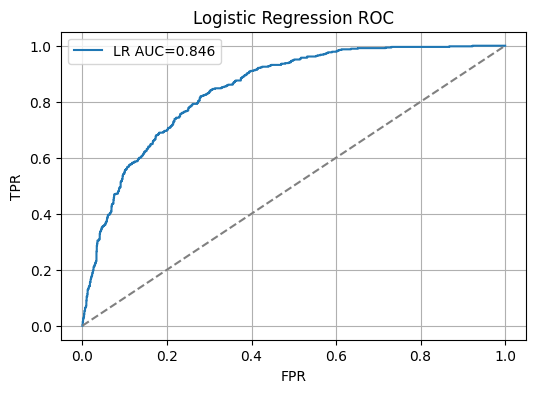

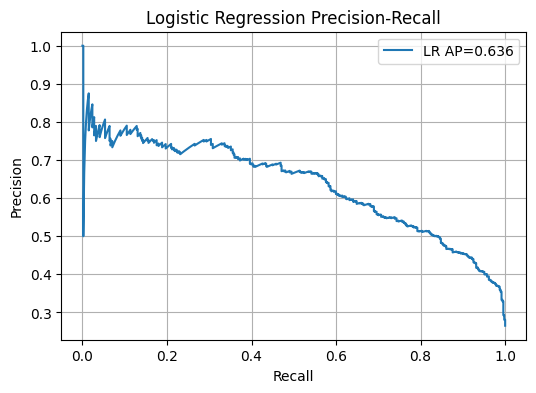

In [28]:
# === Cell 2: Logistic Regression baseline (train, metrics, ROC/PR curves) ===
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report, roc_curve, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import seaborn as sns

lr = LogisticRegression(max_iter=2000, class_weight='balanced', random_state=42)
lr.fit(X_train_scaled, y_train)

y_lr_proba = lr.predict_proba(X_test_scaled)[:,1]
y_lr_pred = (y_lr_proba >= 0.5).astype(int)

roc_auc_lr = roc_auc_score(y_test, y_lr_proba)
ap_lr = average_precision_score(y_test, y_lr_proba)

print("Logistic Regression ROC AUC:", round(roc_auc_lr,4))
print("Average Precision (PR AUC):", round(ap_lr,4))
print("\nClassification Report (threshold=0.5):\n", classification_report(y_test, y_lr_pred))

# ROC
fpr, tpr, _ = roc_curve(y_test, y_lr_proba)
plt.figure(figsize=(6,4)); plt.plot(fpr,tpr,label=f'LR AUC={roc_auc_lr:.3f}'); plt.plot([0,1],[0,1],'--',color='grey')
plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('Logistic Regression ROC'); plt.legend(); plt.grid(True); plt.show()

# Precision-Recall
precision, recall, _ = precision_recall_curve(y_test, y_lr_proba)
plt.figure(figsize=(6,4)); plt.plot(recall, precision, label=f'LR AP={ap_lr:.3f}')
plt.xlabel('Recall'); plt.ylabel('Precision'); plt.title('Logistic Regression Precision-Recall'); plt.legend(); plt.grid(True); plt.show()


RandomForest ROC AUC: 0.8339
Average Precision (PR AUC): 0.6255

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.89      0.86      1294
           1       0.63      0.49      0.55       467

    accuracy                           0.79      1761
   macro avg       0.73      0.69      0.71      1761
weighted avg       0.78      0.79      0.78      1761

Top 15 features (MDI):


,0
TotalCharges,0.131951
tenure,0.123938
AvgMonthlyRevenue,0.121865
MonthlyCharges,0.121587
ContractMonths,0.081303
Cluster,0.055872
InternetService_Fiber optic,0.034179
Contract_Two year,0.030925
PaymentMethod_Electronic check,0.028938
NumServices,0.028246


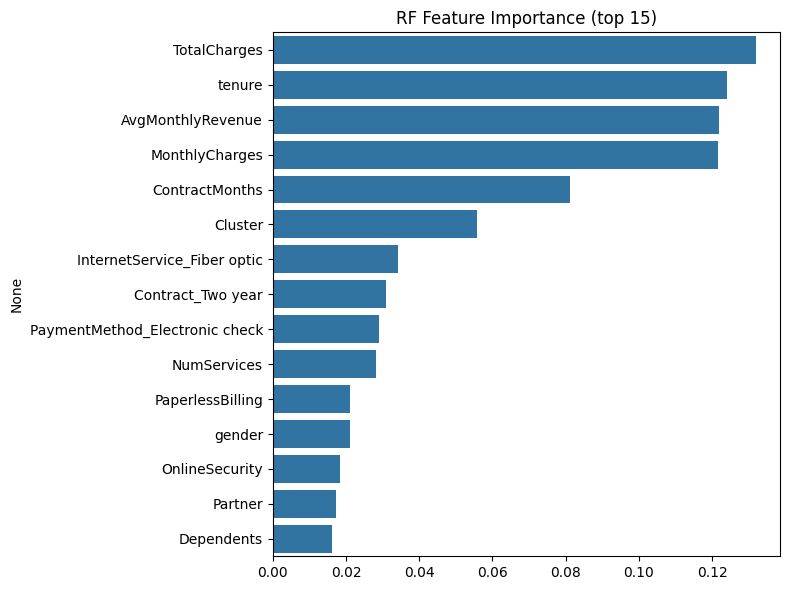

In [29]:
# === Cell 3: Random Forest classifier (metrics + feature importances) ===
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, classification_report
import pandas as pd
import matplotlib.pyplot as plt

rf = RandomForestClassifier(n_estimators=300, random_state=42, class_weight='balanced', n_jobs=-1)
rf.fit(X_train, y_train)

y_rf_proba = rf.predict_proba(X_test)[:,1]
y_rf_pred = rf.predict(X_test)

roc_auc_rf = roc_auc_score(y_test, y_rf_proba)
ap_rf = average_precision_score(y_test, y_rf_proba)

print("RandomForest ROC AUC:", round(roc_auc_rf,4))
print("Average Precision (PR AUC):", round(ap_rf,4))
print("\nClassification Report:\n", classification_report(y_test, y_rf_pred))

# Feature importance (MDI)
feat_imp = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
print("Top 15 features (MDI):")
display(feat_imp.head(15))

plt.figure(figsize=(8,6))
sns.barplot(x=feat_imp.head(15).values, y=feat_imp.head(15).index)
plt.title("RF Feature Importance (top 15)"); plt.tight_layout(); plt.show()


,0
tenure,0.024736
ContractMonths,0.014151
InternetService_Fiber optic,0.011425
MonthlyCharges,0.009767
TotalCharges,0.009540
Cluster,0.006292
AvgMonthlyRevenue,0.005020
OnlineSecurity,0.003521
SeniorCitizen,0.002635
MultipleLines,0.002317


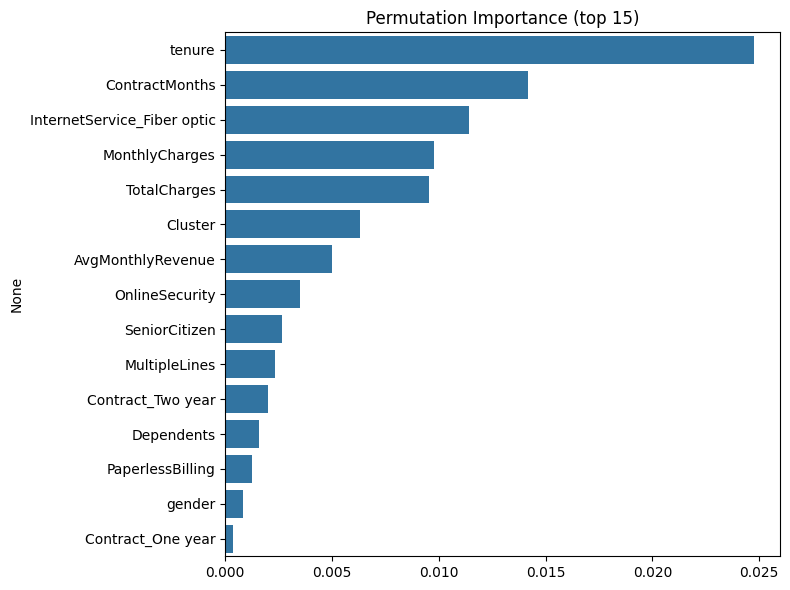

In [30]:
# === Cell 4: Permutation importance (robust ranking) ===
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

r = permutation_importance(rf, X_test, y_test, n_repeats=25, random_state=42, n_jobs=-1)
perm_imp = pd.Series(r.importances_mean, index=X_test.columns).sort_values(ascending=False)
display(perm_imp.head(20))

plt.figure(figsize=(8,6))
sns.barplot(x=perm_imp.head(15).values, y=perm_imp.head(15).index)
plt.title("Permutation Importance (top 15)"); plt.tight_layout(); plt.show()


Numeric PDP features: ['tenure', 'ContractMonths', 'InternetService_Fiber optic']
Numeric PDP error: cannot reshape array of size 1 into shape (2)

Category: InternetService


,InternetService,churn_rate,avg_monthly,count
1,Fiber optic,0.418928,91.500129,3096
0,DSL,0.189591,58.102169,2421
2,No,0.074050,21.079194,1526


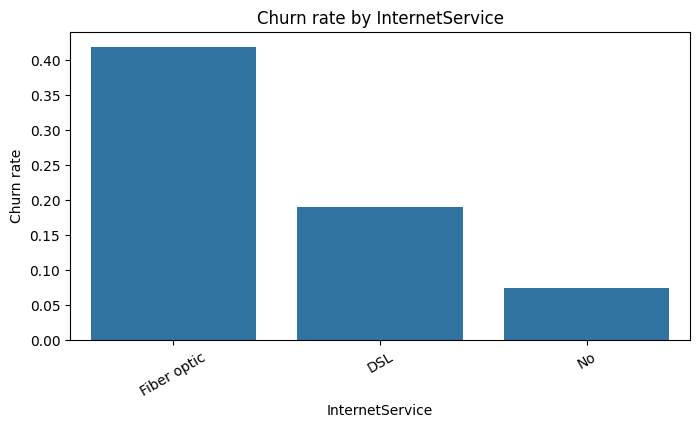

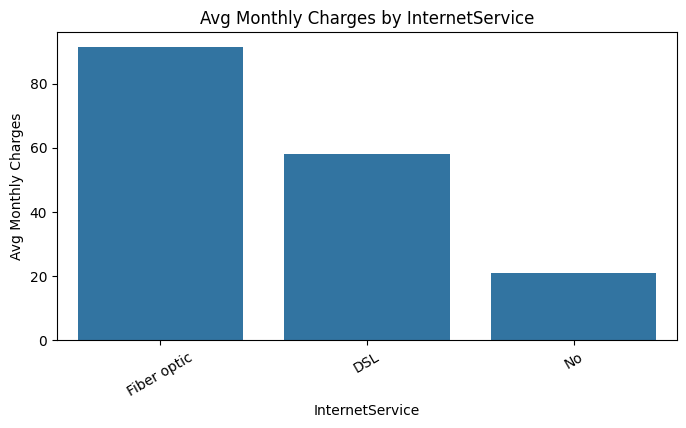


Category: Contract


,Contract,churn_rate,avg_monthly,count
0,Month-to-month,0.427097,66.398490,3875
1,One year,0.112695,65.048608,1473
2,Two year,0.028319,60.770413,1695


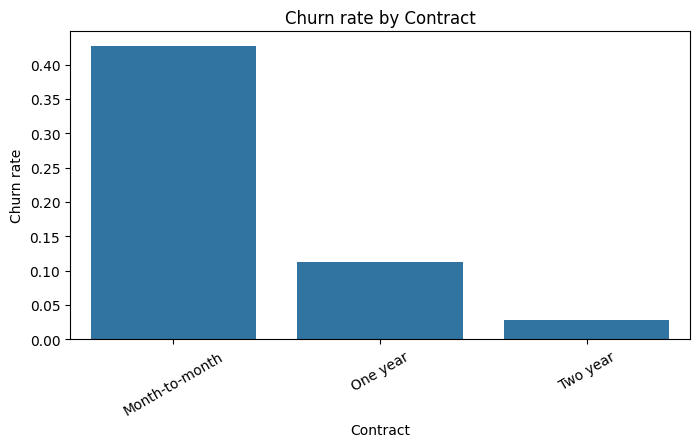

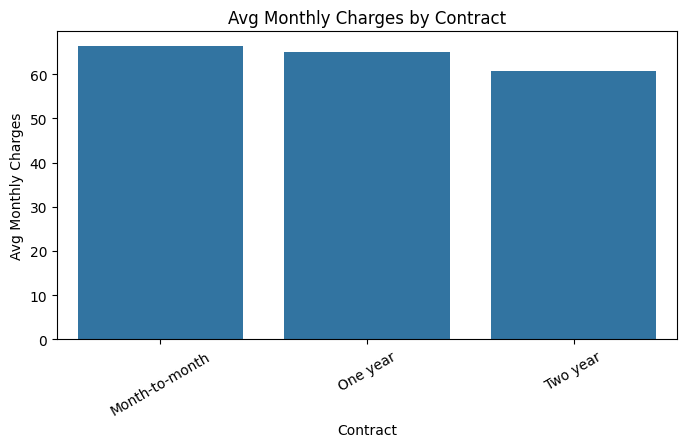


Category: PaymentMethod


,PaymentMethod,churn_rate,avg_monthly,count
2,Electronic check,0.452854,76.255814,2365
3,Mailed check,0.191067,43.917060,1612
0,Bank transfer (automatic),0.167098,67.192649,1544
1,Credit card (automatic),0.152431,66.512385,1522


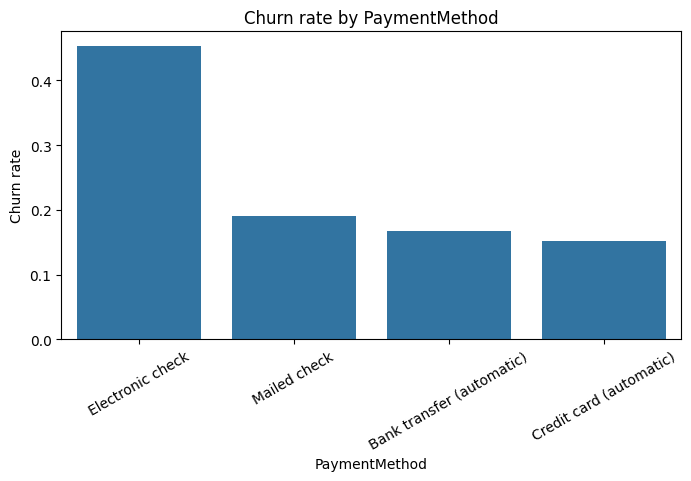

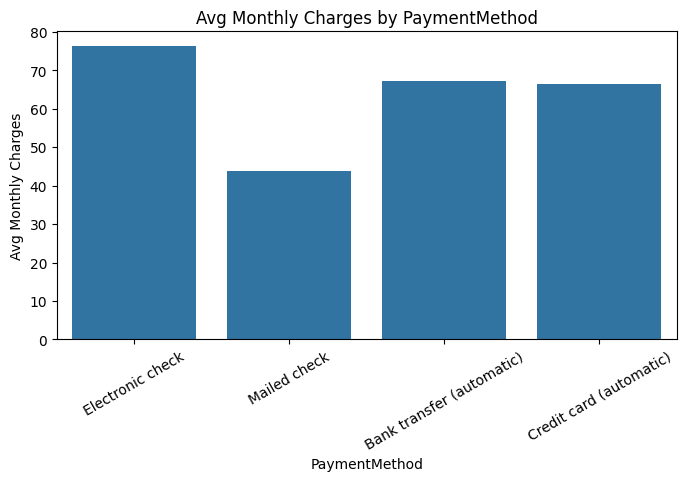

In [31]:
# === Cell A: Robust PDPs for numeric features + grouped bar charts for categorical features ===
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.inspection import PartialDependenceDisplay
import numpy as np
import pandas as pd

# Defensive checks
assert 'rf' in globals(), "RandomForest model 'rf' not found. Run RF training cell first."
assert 'X_test' in globals(), "X_test not found. Run train/test split earlier."
assert 'df_fe' in globals(), "df_fe not found."

# 1) Numeric PDPs (top numeric features from permutation importance)
numeric_cols = X_test.select_dtypes(include=[np.number]).columns.tolist()
# choose up to 3 top numeric features from previously computed perm_imp (if exists)
if 'perm_imp' in globals():
    top_feats = [c for c in perm_imp.index if c in numeric_cols][:3]
else:
    # fallback: select 3 numeric features with highest variance
    top_feats = list(pd.Series(X_train[numeric_cols].var()).sort_values(ascending=False).head(3).index)

print("Numeric PDP features:", top_feats)

# Draw PDPs for numeric features (safe)
try:
    PartialDependenceDisplay.from_estimator(rf, X_test, features=top_feats, kind='average', grid_resolution=20)
    plt.suptitle("Partial Dependence (numeric features)", y=1.02)
    plt.tight_layout()
    plt.show()
except Exception as e:
    print("Numeric PDP error:", e)

# 2) Categorical grouped plots (use original columns if present)
cat_candidates = ['InternetService','Contract','PaymentMethod']
for c in cat_candidates:
    if c in df_fe.columns:
        grp = df_fe.groupby(c).agg(
            churn_rate = ('Churn', lambda s: (s=='Yes').mean() if s.dtype==object else s.mean()),
            avg_monthly = ('MonthlyCharges','mean'),
            count = (c,'count')
        ).reset_index().sort_values('churn_rate', ascending=False)
        print(f"\nCategory: {c}")
        display(grp)
        plt.figure(figsize=(8,4))
        sns.barplot(data=grp, x=c, y='churn_rate')
        plt.ylabel('Churn rate'); plt.title(f'Churn rate by {c}'); plt.xticks(rotation=30); plt.show()
        plt.figure(figsize=(8,4))
        sns.barplot(data=grp, x=c, y='avg_monthly')
        plt.ylabel('Avg Monthly Charges'); plt.title(f'Avg Monthly Charges by {c}'); plt.xticks(rotation=30); plt.show()
    else:
        # fallback: aggregate one-hot OHE columns if they exist
        ohe_matches = [col for col in X_test.columns if col.startswith(c + '_')]
        if len(ohe_matches) > 0:
            print(f"\nOriginal column '{c}' not found. Aggregating one-hot columns:", ohe_matches)
            tmp = []
            for col in ohe_matches:
                # human readable label
                label = col.replace(c + '_','')
                idx = df_fe.index[df_fe[col] == 1] if col in df_fe.columns else df_fe.index[df_fe[col] == 1] if col in df_fe.columns else []
                if len(idx) > 0:
                    churn_rate = (df_fe.loc[idx,'Churn'].map({'Yes':1,'No':0}).mean())
                    avg_mon = df_fe.loc[idx, 'MonthlyCharges'].mean()
                    tmp.append((label, churn_rate, avg_mon, len(idx)))
            grp = pd.DataFrame(tmp, columns=[c,'churn_rate','avg_monthly','count']).sort_values('churn_rate', ascending=False)
            display(grp)
            plt.figure(figsize=(8,4)); sns.barplot(data=grp, x=c, y='churn_rate'); plt.title(f'Churn rate by {c} (from OHE)'); plt.xticks(rotation=30); plt.show()
        else:
            print(f"Neither original column '{c}' nor OHE columns found in data. Skipping {c}.")



InternetService summary:


,InternetService,churn_rate,avg_monthly,count
1,Fiber optic,0.418928,91.500129,3096
0,DSL,0.189591,58.102169,2421
2,No,0.074050,21.079194,1526


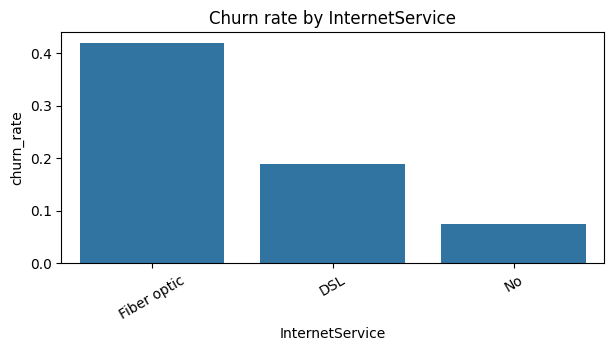


PaymentMethod summary:


,PaymentMethod,churn_rate,avg_monthly,count
2,Electronic check,0.452854,76.255814,2365
3,Mailed check,0.191067,43.917060,1612
0,Bank transfer (automatic),0.167098,67.192649,1544
1,Credit card (automatic),0.152431,66.512385,1522


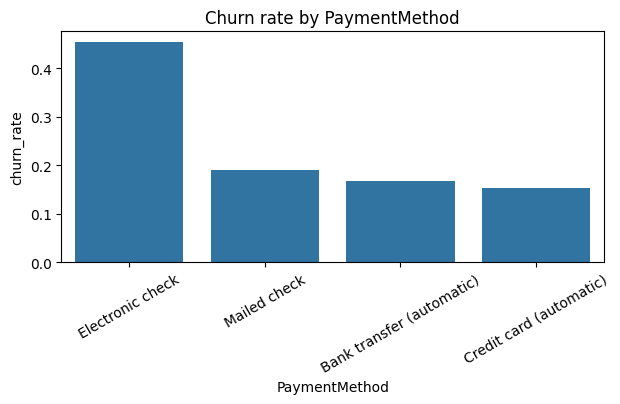


Contract summary:


,Contract,churn_rate,avg_monthly,count
0,Month-to-month,0.427097,66.398490,3875
1,One year,0.112695,65.048608,1473
2,Two year,0.028319,60.770413,1695


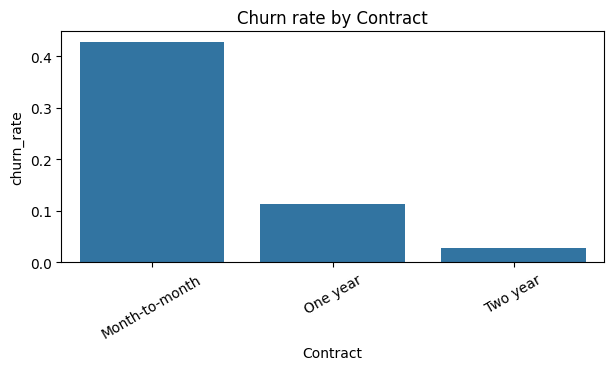

In [32]:
# === Cell E: Explicit grouped analysis for InternetService (and PaymentMethod if needed) ===
for col in ['InternetService','PaymentMethod','Contract']:
    if col in df_fe.columns:
        summary = df_fe.groupby(col).agg(
            churn_rate = ('Churn', lambda s: (s=='Yes').mean() if s.dtype==object else s.mean()),
            avg_monthly = ('MonthlyCharges','mean'),
            count = (col,'count')
        ).reset_index().sort_values('churn_rate', ascending=False)
        print(f"\n{col} summary:")
        display(summary)
        plt.figure(figsize=(7,3))
        sns.barplot(data=summary, x=col, y='churn_rate')
        plt.title(f'Churn rate by {col}'); plt.xticks(rotation=30); plt.show()
    else:
        print(f"{col} not present in df_fe; skipping grouped plot.")


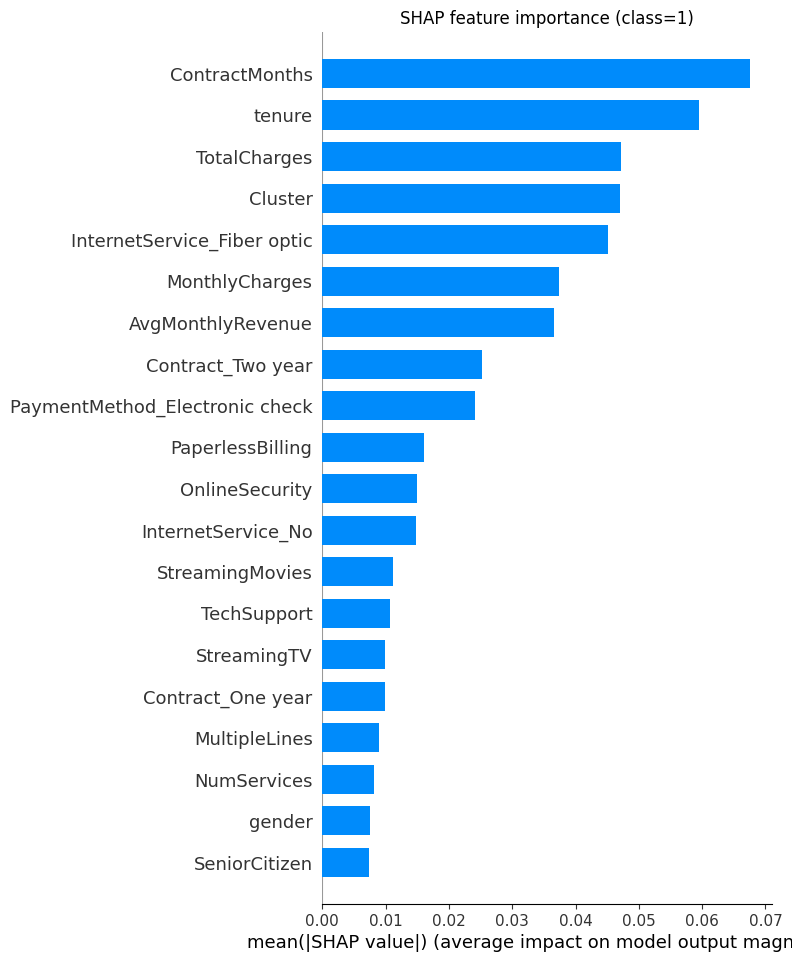

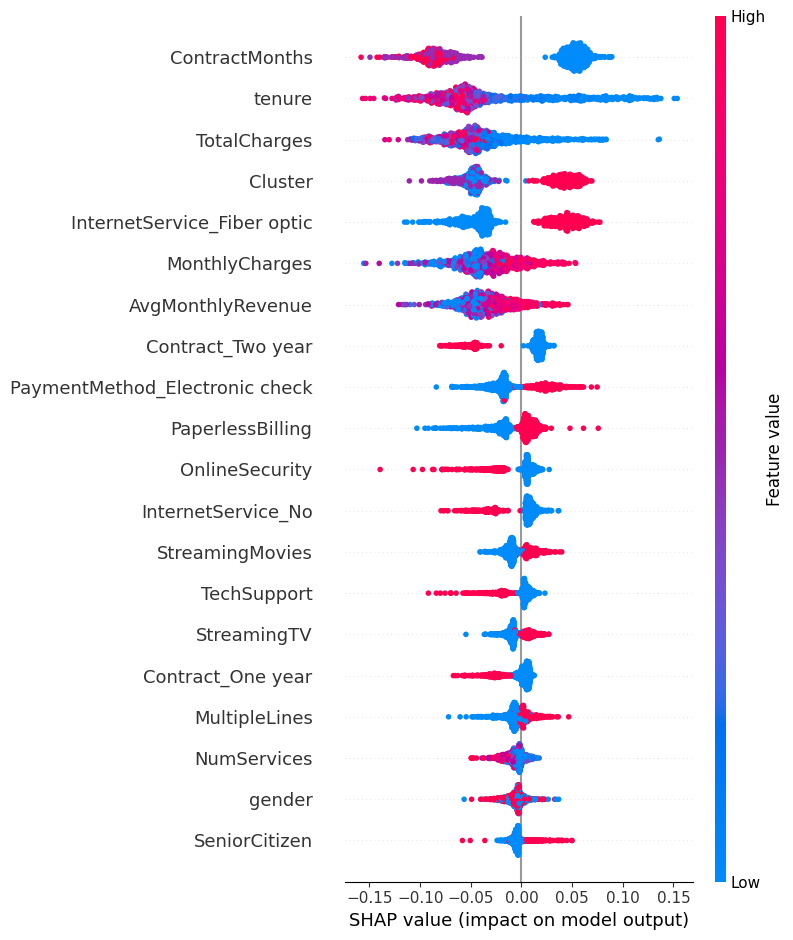

Sample index for force plot (original X_test index): 1739


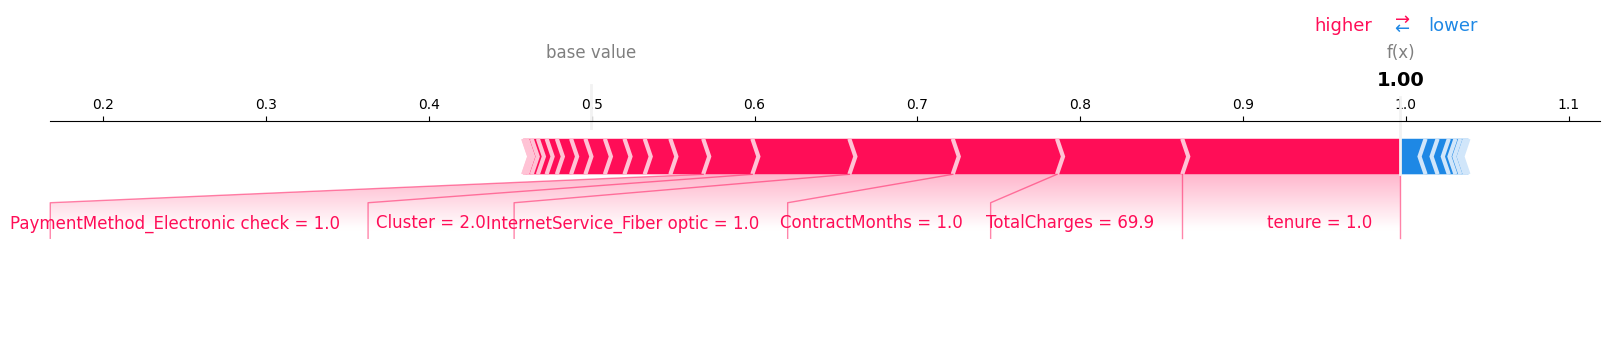

In [33]:
# === Cell 6: SHAP explanations (global summary + sample force plot) ===
!pip install -q shap
import shap, numpy as np
shap.initjs()

# Use TreeExplainer for RF
explainer = shap.TreeExplainer(rf)
# sample for speed
X_shap = X_test.sample(n=min(1000, X_test.shape[0]), random_state=42)

# Calculate SHAP values
# For classifiers, explainer.shap_values often returns a 3D array: (n_samples, n_features, n_classes).
# We need to select the SHAP values for the positive class (class 1).
shap_values = explainer.shap_values(X_shap)

# Extract SHAP values and expected value for the positive class (class 1)
# This assumes shap_values is a 3D array (n_samples, n_features, n_classes)
# and explainer.expected_value is a list [expected_value_class0, expected_value_class1]
if shap_values.ndim == 3 and len(explainer.expected_value) > 1:
    shap_values_for_class_1 = shap_values[:, :, 1]
    expected_value_class_1 = explainer.expected_value[1]
elif shap_values.ndim == 2: # Fallback for single-output (e.g., regression or already selected class)
    print("Warning: shap_values is 2D. Assuming it's already for the class of interest.")
    shap_values_for_class_1 = shap_values
    expected_value_class_1 = explainer.expected_value # Could be scalar or 0-indexed list
else:
    raise ValueError("Unexpected shape for shap_values or expected_value.")

# Global summary (bar)
shap.summary_plot(shap_values_for_class_1, X_shap, plot_type="bar", max_display=20, show=False)
plt.title("SHAP feature importance (class=1)")
plt.show()

# Global summary (dot)
shap.summary_plot(shap_values_for_class_1, X_shap, show=False)
plt.show()

# Force plot for one high-risk sample
# Find the sample with the highest SHAP sum for class 1
high_idx_in_X_shap = np.argmax(shap_values_for_class_1.sum(axis=1))
sample_to_plot_shap = shap_values_for_class_1[high_idx_in_X_shap, :]
sample_to_plot_features = X_shap.iloc[high_idx_in_X_shap, :]

print("Sample index for force plot (original X_test index):", sample_to_plot_features.name)
shap.force_plot(expected_value_class_1, sample_to_plot_shap, sample_to_plot_features, matplotlib=True, show=True)

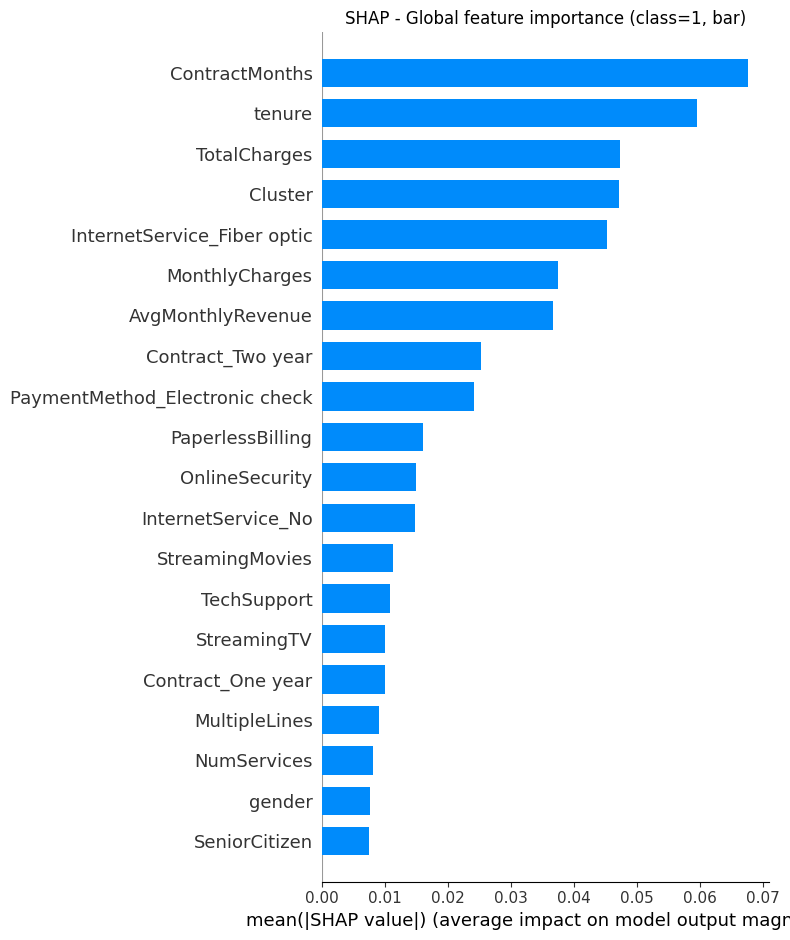

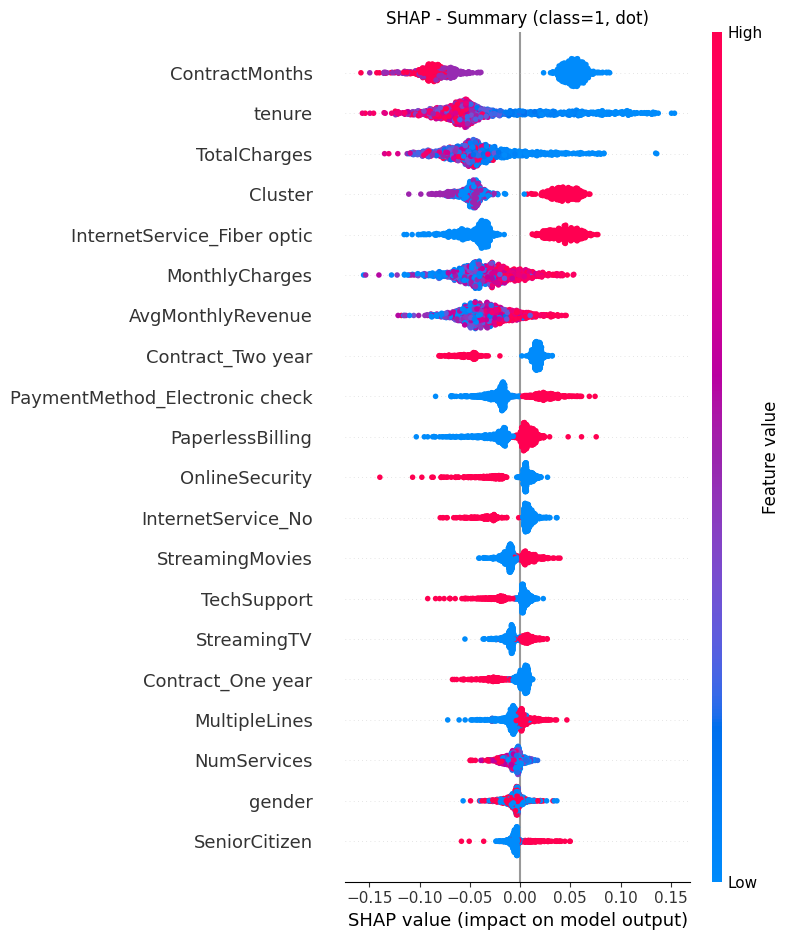

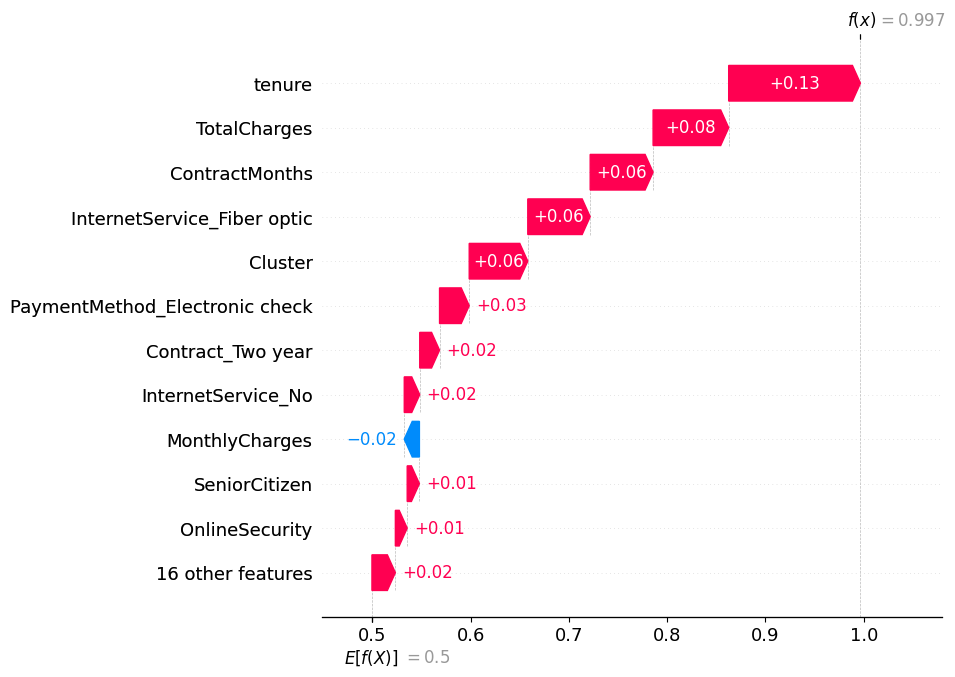

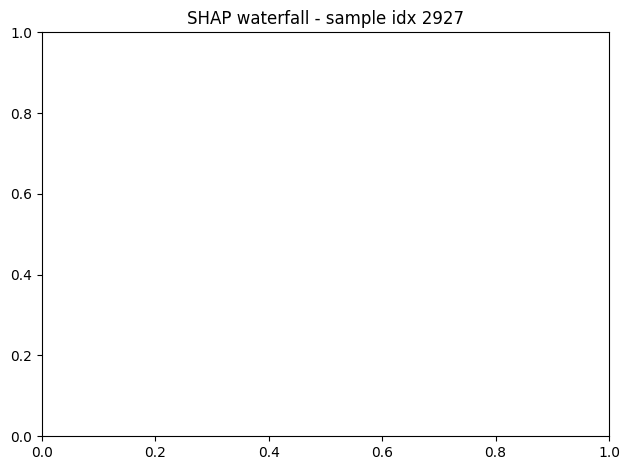

In [34]:
# === Cell B: SHAP summary + waterfall for a representative high-risk sample (static) ===
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Defensive checks
assert 'rf' in globals(), "RandomForest 'rf' not found."
assert 'X_test' in globals(), "X_test not found."
try:
    import shap
except Exception:
    !pip install -q shap
    import shap

# use TreeExplainer
explainer = shap.TreeExplainer(rf)
# sample for speed
sample_size = min(1000, X_test.shape[0])
X_shap = X_test.sample(n=sample_size, random_state=42)

# Calculate SHAP values
shap_values_raw = explainer.shap_values(X_shap) # Renamed to avoid confusion with processed version

# Extract SHAP values and expected value for the positive class (class 1)
# This assumes shap_values_raw is either a list [array_class0, array_class1] or a 3D array (n_samples, n_features, n_classes)
if isinstance(shap_values_raw, list):
    # For binary classification with TreeExplainer, it's typically a list of two 2D arrays
    shap_values_for_class_1 = shap_values_raw[1]
    expected_value_class_1 = explainer.expected_value[1]
elif isinstance(shap_values_raw, np.ndarray) and shap_values_raw.ndim == 3:
    # Handle cases where explainer.shap_values returns a 3D array (n_samples, n_features, n_classes)
    shap_values_for_class_1 = shap_values_raw[:, :, 1]
    expected_value_class_1 = explainer.expected_value[1]
elif isinstance(shap_values_raw, np.ndarray) and shap_values_raw.ndim == 2: # Fallback for single-output or already selected class
    print("Warning: shap_values is 2D. Assuming it's already for the class of interest.")
    shap_values_for_class_1 = shap_values_raw
    expected_value_class_1 = explainer.expected_value # Could be scalar or 0-indexed list
else:
    raise ValueError("Unexpected shape/type for shap_values_raw or expected_value.")


# Global SHAP plots (bar + dot)
plt.figure(figsize=(8,6))
shap.summary_plot(shap_values_for_class_1, X_shap, plot_type='bar', show=False)
plt.title("SHAP - Global feature importance (class=1, bar)")
plt.tight_layout()
plt.savefig('shap_summary_bar.png', dpi=150)
plt.show()

plt.figure(figsize=(10,6))
shap.summary_plot(shap_values_for_class_1, X_shap, show=False)
plt.title("SHAP - Summary (class=1, dot)")
plt.tight_layout()
plt.savefig('shap_summary_dot.png', dpi=150)
plt.show()

# Waterfall for a single high-risk sample:
# choose the test sample with highest predicted churn prob if available
if 'y_rf_proba' in globals():
    # ensure y_rf_proba corresponds to X_test ordering
    # build df_test with probs
    df_test_probs = X_test.copy()
    df_test_probs['y_proba'] = y_rf_proba
    idx = df_test_probs['y_proba'].idxmax()
    try:
        sample = X_test.loc[idx:idx]
        sv_raw = explainer.shap_values(sample) # SHAP values for the single sample

        # Extract SHAP values for the positive class (class 1) for the single sample
        if isinstance(sv_raw, list):
            sv_for_class_1_sample = sv_raw[1]
            expected_value_class_1_sample = explainer.expected_value[1]
        elif isinstance(sv_raw, np.ndarray) and sv_raw.ndim == 3:
            sv_for_class_1_sample = sv_raw[:, :, 1]
            expected_value_class_1_sample = explainer.expected_value[1]
        elif isinstance(sv_raw, np.ndarray) and sv_raw.ndim == 2:
            sv_for_class_1_sample = sv_raw
            expected_value_class_1_sample = explainer.expected_value
        else:
            raise ValueError("Unexpected shape/type for sv_raw.")


        plt.figure(figsize=(8,6))
        # sv_for_class_1_sample is already (1, n_features), so take the 0th element to get (n_features,)
        shap.plots._waterfall.waterfall_legacy(expected_value_class_1_sample, sv_for_class_1_sample[0], feature_names=sample.columns, max_display=12)
        plt.title(f"SHAP waterfall - sample idx {idx}")
        plt.tight_layout()
        plt.savefig('shap_waterfall_sample.png', dpi=150)
        plt.show()
    except Exception as e:
        print("Waterfall error or unsupported SHAP version fallback:", e)
        # fallback: use decision plot
        try:
            shap.decision_plot(expected_value_class_1_sample, sv_for_class_1_sample, sample, feature_names=sample.columns, show=True)
        except Exception as e2:
            print("Fallback decision plot failed:", e2)
else:
    print("y_rf_proba not found; selecting top SHAP magnitude sample")
    idx = X_shap.index[0]
    sv_raw = explainer.shap_values(X_shap.loc[idx:idx]) # Get SHAP values for the first sample in X_shap

    # Extract SHAP values for the positive class (class 1) for the single sample
    if isinstance(sv_raw, list):
        sv_for_class_1_sample = sv_raw[1]
        expected_value_class_1_sample = explainer.expected_value[1]
    elif isinstance(sv_raw, np.ndarray) and sv_raw.ndim == 3:
        sv_for_class_1_sample = sv_raw[:, :, 1]
        expected_value_class_1_sample = explainer.expected_value[1]
    elif isinstance(sv_raw, np.ndarray) and sv_raw.ndim == 2:
        sv_for_class_1_sample = sv_raw
        expected_value_class_1_sample = explainer.expected_value
    else:
        raise ValueError("Unexpected shape/type for sv_raw.")

    plt.figure(figsize=(8,6))
    shap.plots._waterfall.waterfall_legacy(expected_value_class_1_sample, sv_for_class_1_sample[0], feature_names=X_shap.columns, max_display=12)
    plt.show()

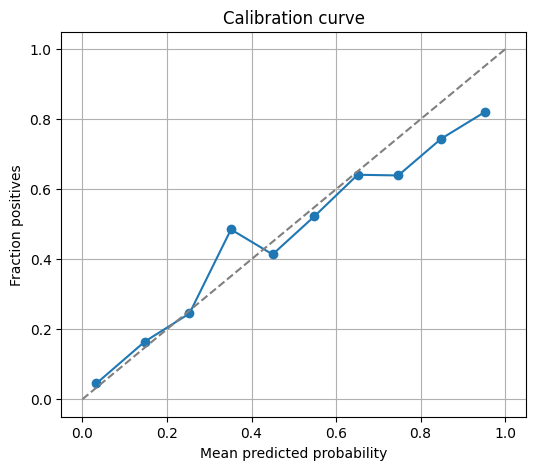

Approx avg monthly charge used: 64.48


,threshold,targeted,prevented,revenue_retained,cost,net_benefit
0,0.05,1290,322.50,124762.888416,12900.0,111862.888416
1,0.10,1090,272.50,105419.804940,10900.0,94519.804940
2,0.15,938,234.50,90719.061499,9380.0,81339.061499
3,0.20,825,206.25,79790.219336,8250.0,71540.219336
4,0.25,723,180.75,69925.246763,7230.0,62695.246763
5,0.30,629,157.25,60833.997530,6290.0,54543.997530
6,0.35,550,137.50,53193.479557,5500.0,47693.479557
7,0.40,488,122.00,47197.123680,4880.0,42317.123680
8,0.45,426,106.50,41200.767802,4260.0,36940.767802
9,0.50,371,92.75,35881.419847,3710.0,32171.419847


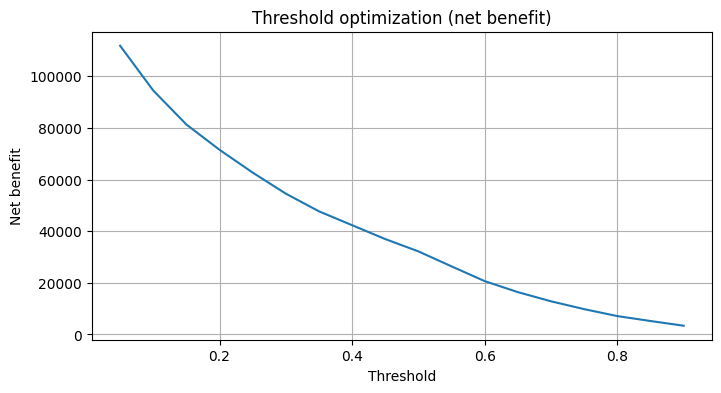

In [35]:
# === Cell 7: Calibration & threshold selection (business-aware) ===
from sklearn.calibration import calibration_curve
import numpy as np

# Use RF predicted probabilities
probs = y_rf_proba
y_true = y_test.values

# Calibration curve
prob_true, prob_pred = calibration_curve(y_true, probs, n_bins=10)
plt.figure(figsize=(6,5)); plt.plot(prob_pred, prob_true, marker='o'); plt.plot([0,1],[0,1],'--', color='grey')
plt.xlabel('Mean predicted probability'); plt.ylabel('Fraction positives'); plt.title('Calibration curve'); plt.grid(True); plt.show()

# Threshold scan: assume business assumptions
# average monthly revenue per customer approximated by avg MonthlyCharges in test
avg_monthly = X_test['MonthlyCharges'].mean() if 'MonthlyCharges' in X_test.columns else df_fe['MonthlyCharges'].mean()
print("Approx avg monthly charge used:", round(avg_monthly,2))

# Business parameters (edit as needed)
coupon_cost = 10.0   # cost to provide a retention coupon / offer (currency)
lifetime_months_saved = 6  # if retention works, months retained
retention_success_rate = 0.25  # if we offer coupon, chance they stay

thresholds = np.linspace(0.05, 0.9, 18)
results = []
for t in thresholds:
    preds = (probs >= t).astype(int)
    # customers targeted
    targeted = preds.sum()
    # expected prevented churns = targeted * retention_success_rate
    prevented = targeted * retention_success_rate
    # expected revenue retained = prevented * avg_monthly * lifetime_months_saved
    revenue_retained = prevented * avg_monthly * lifetime_months_saved
    cost = targeted * coupon_cost
    net_benefit = revenue_retained - cost
    results.append((t, targeted, prevented, revenue_retained, cost, net_benefit))

res_df = pd.DataFrame(results, columns=['threshold','targeted','prevented','revenue_retained','cost','net_benefit'])
display(res_df.sort_values('net_benefit', ascending=False).head(10))
# Plot threshold vs net benefit
plt.figure(figsize=(8,4)); plt.plot(res_df['threshold'], res_df['net_benefit']); plt.xlabel('Threshold'); plt.ylabel('Net benefit'); plt.title('Threshold optimization (net benefit)'); plt.grid(True); plt.show()


In [36]:
# === Cell 8: Inverse-transform KMeans centroids to human-readable values ===
import numpy as np
assert 'kmeans_final' in globals(), "kmeans_final not found. Ensure you have the trained KMeans model."
# Use X_scaled_df or X_scaled; prefer X_scaled_df if present
if 'X_scaled_df' in globals():
    scaled_df = X_scaled_df
else:
    # create from X_scaled (array) if X_scaled exists
    if 'X_scaled' in globals():
        scaled_df = pd.DataFrame(X_scaled, columns=X.columns)
    else:
        raise KeyError("Scaled clustering matrix not found. Ensure X_scaled or X_scaled_df exists.")
# centroids in scaled space
centroids_scaled = kmeans_final.cluster_centers_
# inverse transform using 'scaler' (this is the scaler used earlier for clustering features)
if 'scaler' in globals():
    centroids_orig = scaler.inverse_transform(centroids_scaled)
    centroids_df = pd.DataFrame(centroids_orig, columns=X.columns)
    display(centroids_df.T.round(2))
else:
    print("scaler variable not found. Showing scaled centroids instead.")
    display(pd.DataFrame(centroids_scaled, columns=X.columns).T.round(3))


,0,1,2
gender,0.50,0.51,0.50
SeniorCitizen,0.16,0.04,0.24
Partner,0.71,0.46,0.33
Dependents,0.38,0.41,0.16
tenure,56.07,28.23,17.43
PhoneService,0.90,0.90,0.90
MultipleLines,0.64,0.19,0.41
OnlineSecurity,0.61,0.06,0.19
OnlineBackup,0.70,0.04,0.28
DeviceProtection,0.74,0.03,0.26


In [37]:
# === Cell 9: KMeans stability (Adjusted Rand Index across runs) ===
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
import itertools, numpy as np

def kmeans_stability(X_scaled_arr, k=3, runs=10):
    labels_runs = []
    for i in range(runs):
        km = KMeans(n_clusters=k, random_state=42+i, n_init=10).fit(X_scaled_arr)
        labels_runs.append(km.labels_)
    aris = []
    for a,b in itertools.combinations(range(runs),2):
        aris.append(adjusted_rand_score(labels_runs[a], labels_runs[b]))
    return {'mean_ari': np.mean(aris), 'median_ari': np.median(aris), 'min_ari': np.min(aris), 'max_ari': np.max(aris)}

# Run stability
if 'X_scaled' in globals():
    stab = kmeans_stability(X_scaled, k=kmeans_final.n_clusters, runs=8)
    print("KMeans stability (ARI stats):", stab)
else:
    print("X_scaled not found; stability check requires scaled feature matrix.")


KMeans stability (ARI stats): {'mean_ari': np.float64(0.9929680458004861), 'median_ari': np.float64(0.9907504754024208), 'min_ari': np.float64(0.9875717822804945), 'max_ari': np.float64(1.0)}


In [38]:
# === Cell 10: Compare clustering methods (Silhouette for KMeans/GMM/Agglomerative) ===
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

if 'X_scaled' not in globals():
    raise KeyError("X_scaled not found for clustering comparison")

def compare_cluster_methods(X_scaled_arr, k=3):
    results = {}
    # KMeans (reuse final model)
    km_labels = kmeans_final.predict(X_scaled_arr)
    results['KMeans'] = silhouette_score(X_scaled_arr, km_labels)
    # GMM
    gmm = GaussianMixture(n_components=k, random_state=42).fit(X_scaled_arr)
    gmm_labels = gmm.predict(X_scaled_arr)
    results['GMM'] = silhouette_score(X_scaled_arr, gmm_labels)
    # Agglomerative
    agg = AgglomerativeClustering(n_clusters=k).fit(X_scaled_arr)
    agg_labels = agg.labels_
    results['Agglomerative'] = silhouette_score(X_scaled_arr, agg_labels)
    return results

comp = compare_cluster_methods(X_scaled, k=kmeans_final.n_clusters)
print("Clustering comparison (silhouette):", comp)


Clustering comparison (silhouette): {'KMeans': np.float64(0.16368443103843502), 'GMM': np.float64(0.155408641131659), 'Agglomerative': np.float64(0.14729906544415386)}


In [39]:
# === Cell C: RandomizedSearchCV for RandomForest (small search) ===
from sklearn.model_selection import RandomizedSearchCV
import numpy as np
from scipy.stats import randint as sp_randint

# Defensive checks
assert 'X_train' in globals() and 'y_train' in globals(), "Train data not found."

param_dist = {
    'n_estimators': [100, 200, 350],
    'max_depth': [None, 8, 12, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

rf_base = RandomForestClassifier(class_weight='balanced', random_state=42, n_jobs=-1)
rs = RandomizedSearchCV(
    rf_base, param_distributions=param_dist,
    n_iter=20, scoring='roc_auc', cv=3, verbose=1, random_state=42, n_jobs=-1
)
rs.fit(X_train, y_train)

print("Best params:", rs.best_params_)
print("Best CV ROC AUC:", rs.best_score_)

# Replace rf with the tuned model for downstream explainability if desired
rf_tuned = rs.best_estimator_
# Evaluate tuned model on test
y_tuned_proba = rf_tuned.predict_proba(X_test)[:,1]
from sklearn.metrics import roc_auc_score
print("Tuned RF ROC AUC on test:", roc_auc_score(y_test, y_tuned_proba))
# Optionally assign rf = rf_tuned to use tuned model for SHAP and permutation
rf = rf_tuned
y_rf_proba = y_tuned_proba
print("Assigned tuned RF to variable 'rf' and updated y_rf_proba.")


Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best params: {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'log2', 'max_depth': 8}
Best CV ROC AUC: 0.847989722063751
Tuned RF ROC AUC on test: 0.845841786668167
Assigned tuned RF to variable 'rf' and updated y_rf_proba.


Best threshold by net benefit: 0.05


,0
threshold,0.050000
targeted,1488.000000
revenue_retained,143912.541056
cost,14880.000000
net_benefit,129032.541056
precision,0.311828
recall,0.993576
f1,0.474680


,threshold,targeted,revenue_retained,cost,net_benefit,precision,recall,f1
0,0.05,1488,143912.541056,14880.0,129032.541056,0.311828,0.993576,0.474680
1,0.10,1357,131242.821380,13570.0,117672.821380,0.340457,0.989293,0.506579
2,0.15,1252,121087.702555,12520.0,108567.702555,0.362620,0.972163,0.528214
3,0.20,1143,110545.722061,11430.0,99115.722061,0.388451,0.950749,0.551553
4,0.25,1059,102421.627002,10590.0,91831.627002,0.411709,0.933619,0.571429
5,0.30,974,94200.816525,9740.0,84460.816525,0.441478,0.920771,0.596808
6,0.35,885,85593.144378,8850.0,76743.144378,0.465537,0.882227,0.609467
7,0.40,804,77759.195571,8040.0,69719.195571,0.493781,0.850107,0.624705


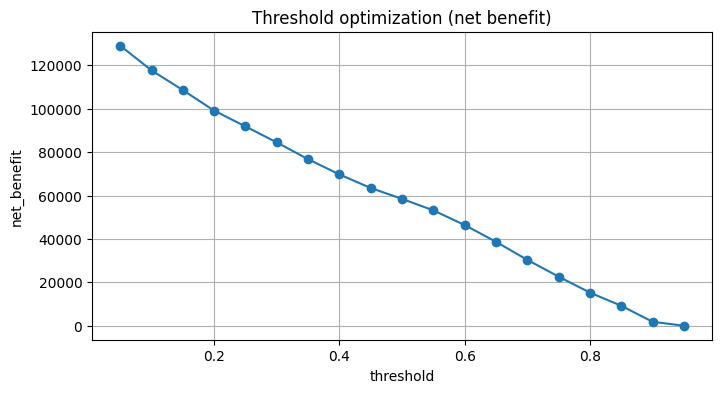

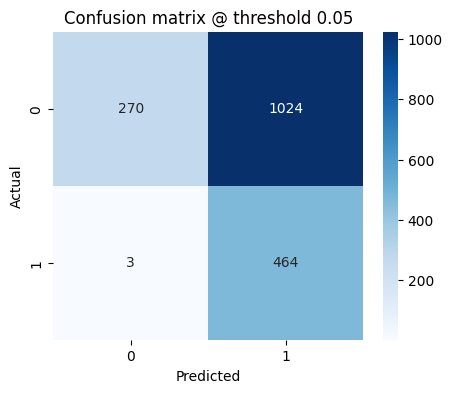

Classification report @ chosen threshold:
              precision    recall  f1-score   support

           0       0.99      0.21      0.34      1294
           1       0.31      0.99      0.47       467

    accuracy                           0.42      1761
   macro avg       0.65      0.60      0.41      1761
weighted avg       0.81      0.42      0.38      1761



In [40]:
# === Cell D: Threshold scan, choose best threshold by net benefit, show metrics at chosen threshold ===
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# Defensive checks
assert 'y_rf_proba' in globals() and 'y_test' in globals(), "Predicted probabilities or y_test missing."

probs = y_rf_proba
ytrue = y_test.values

# Business params (edit if you have better numbers)
coupon_cost = 10.0   # cost to provide retention offer per targeted customer
lifetime_months_saved = 6
retention_success_rate = 0.25

thresholds = np.linspace(0.05, 0.95, 19)
records = []
for t in thresholds:
    preds = (probs >= t).astype(int)
    targeted = preds.sum()
    prevented = targeted * retention_success_rate
    avg_monthly = X_test['MonthlyCharges'].mean() if 'MonthlyCharges' in X_test.columns else df_fe['MonthlyCharges'].mean()
    revenue_retained = prevented * avg_monthly * lifetime_months_saved
    cost = targeted * coupon_cost
    net_benefit = revenue_retained - cost
    # metric at t
    precision = precision_score(ytrue, preds, zero_division=0)
    recall = recall_score(ytrue, preds, zero_division=0)
    f1 = f1_score(ytrue, preds, zero_division=0)
    records.append((t, targeted, revenue_retained, cost, net_benefit, precision, recall, f1))

res_df = pd.DataFrame(records, columns=['threshold','targeted','revenue_retained','cost','net_benefit','precision','recall','f1'])
# choose threshold with maximum net_benefit
best_row = res_df.loc[res_df['net_benefit'].idxmax()]
best_threshold = best_row['threshold']
print("Best threshold by net benefit:", best_threshold)
display(best_row)

# Show top thresholds
display(res_df.sort_values('net_benefit', ascending=False).head(8))

# plot net benefit vs threshold
plt.figure(figsize=(8,4)); plt.plot(res_df['threshold'], res_df['net_benefit'], marker='o'); plt.xlabel('threshold'); plt.ylabel('net_benefit'); plt.title('Threshold optimization (net benefit)'); plt.grid(True); plt.show()

# Evaluate and show confusion matrix & classification report at chosen threshold
chosen_preds = (probs >= best_threshold).astype(int)
cm = confusion_matrix(ytrue, chosen_preds)
plt.figure(figsize=(5,4)); sns.heatmap(cm, annot=True, fmt='d', cmap='Blues'); plt.xlabel('Predicted'); plt.ylabel('Actual'); plt.title(f'Confusion matrix @ threshold {best_threshold:.2f}'); plt.show()
print("Classification report @ chosen threshold:")
print(classification_report(ytrue, chosen_preds))


In [41]:
# === Cell F: KMeans stability & clustering comparison summary ===
from sklearn.metrics import adjusted_rand_score, silhouette_score
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering
import numpy as np

# Stability: run KMeans multiple times and compute ARI distribution
def kmeans_ari_runs(X_scaled_arr, k=3, runs=8):
    labels = []
    for i in range(runs):
        km = KMeans(n_clusters=k, random_state=42+i, n_init=10).fit(X_scaled_arr)
        labels.append(km.labels_)
    aris = []
    for i in range(len(labels)):
        for j in range(i+1, len(labels)):
            aris.append(adjusted_rand_score(labels[i], labels[j]))
    return np.mean(aris), np.median(aris), np.min(aris), np.max(aris)

if 'X_scaled' in globals():
    mean_ari, med_ari, min_ari, max_ari = kmeans_ari_runs(X_scaled, k=kmeans_final.n_clusters, runs=8)
    print(f"KMeans ARI stats (mean, median, min, max): {mean_ari:.3f}, {med_ari:.3f}, {min_ari:.3f}, {max_ari:.3f}")
else:
    print("X_scaled missing — stability check skipped.")

# Alternative clustering silhouette comparison
if 'X_scaled' in globals():
    k = kmeans_final.n_clusters if 'kmeans_final' in globals() else 3
    km_labels = kmeans_final.predict(X_scaled) if 'kmeans_final' in globals() else KMeans(n_clusters=k, random_state=42).fit_predict(X_scaled)
    sil_km = silhouette_score(X_scaled, km_labels)
    gmm = GaussianMixture(n_components=k, random_state=42).fit(X_scaled)
    sil_gmm = silhouette_score(X_scaled, gmm.predict(X_scaled))
    agg = AgglomerativeClustering(n_clusters=k).fit(X_scaled)
    sil_agg = silhouette_score(X_scaled, agg.labels_)
    print("Silhouette scores: KMeans={:.3f}, GMM={:.3f}, Agglomerative={:.3f}".format(sil_km, sil_gmm, sil_agg))
else:
    print("X_scaled missing — clustering comparison skipped.")


KMeans ARI stats (mean, median, min, max): 0.993, 0.991, 0.988, 1.000
Silhouette scores: KMeans=0.164, GMM=0.155, Agglomerative=0.147


In [42]:
# === Cell 11: Export final datasets & models ===
import joblib, os
# add Cluster and churn probabilities to df_fe for export
df_export = df_fe.copy()
# ensure rf & churn scaler exist
if 'rf' in globals():
    df_export.loc[X_test.index, 'churn_proba_rf'] = y_rf_proba
else:
    print("RF not present—skipping churn_proba column.")

# Save CSV
out_csv = 'telco_clusters_with_features.csv'
df_export.to_csv(out_csv, index=False)
print("Saved CSV:", out_csv)

# Save models (if present)
if 'rf' in globals():
    joblib.dump(rf, 'rf_churn_model.joblib')
if 'churn_scaler' in globals():
    joblib.dump(churn_scaler, 'churn_scaler.joblib')
if 'kmeans_final' in globals():
    joblib.dump(kmeans_final, 'kmeans_telco_model.joblib')

print("Saved models (if available) to working directory.")


Saved CSV: telco_clusters_with_features.csv
Saved models (if available) to working directory.


In [43]:
# === Cell 12: Automated personas and executive summary ===
def persona_and_actions(df, cluster_label):
    grp = df[df['Cluster']==cluster_label]
    n = len(grp)
    churn = (grp['Churn']=='Yes').mean()*100 if grp['Churn'].dtype == 'object' else (grp['Churn'].mean()*100)
    avg_charges = grp['MonthlyCharges'].mean()
    median_tenure = grp['tenure'].median()
    services = grp['NumServices'].mean()
    contract_top = grp['Contract'].mode().iloc[0] if 'Contract' in grp.columns else 'N/A'
    internet_top = grp['InternetService'].mode().iloc[0] if 'InternetService' in grp.columns else 'N/A'

    persona = {
        'cluster': cluster_label,
        'customers': n,
        'median_tenure': int(median_tenure),
        'avg_monthly': round(avg_charges,2),
        'avg_services': round(services,2),
        'dominant_contract': contract_top,
        'dominant_internet': internet_top,
        'churn_pct': round(churn,2)
    }
    # recommended actions
    actions = []
    if persona['churn_pct'] > 25:
        actions.append("High-priority retention campaigns: targeted discounts, onboarding support.")
    elif persona['avg_monthly'] > df_fe['MonthlyCharges'].median():
        actions.append("Protect loyalty: offer cross-sell, premium bundles, loyalty rewards.")
    else:
        actions.append("Upsell low-cost add-ons; educate about value offers.")
    # KPI estimate
    persona['estimated_monthly_revenue'] = persona['customers'] * persona['avg_monthly']
    return persona, actions

# Generate for all clusters
personas = []
for c in sorted(df_fe['Cluster'].unique()):
    p, acts = persona_and_actions(df_fe, c)
    personas.append((p, acts))

# Print personas
for p, acts in personas:
    print(f"Cluster {p['cluster']} — Customers: {p['customers']}, Median tenure: {p['median_tenure']} months, Avg monthly: ₹{p['avg_monthly']}, Churn%: {p['churn_pct']}")
    print("Top actions:", "; ".join(acts))
    print("Estimated monthly revenue (cluster): ₹", int(p['estimated_monthly_revenue']))
    print("-"*80)

# Executive summary (short)
print("\nEXECUTIVE SUMMARY:")
total_customers = len(df_fe)
print(f"- Total customers analysed: {total_customers}")
for p, _ in personas:
    print(f"  Cluster {p['cluster']}: {p['customers']} customers, Median tenure {p['median_tenure']}m, Churn {p['churn_pct']}%, Avg monthly ₹{p['avg_monthly']}")
print("\nKey recommendation: Prioritize Cluster with highest churn for a targeted retention campaign; simulate coupon offers with cost/benefit thresholds and deploy for customers with predicted churn probability above the chosen threshold.")


Cluster 0 — Customers: 2188, Median tenure: 60 months, Avg monthly: ₹87.93, Churn%: 12.52
Top actions: Protect loyalty: offer cross-sell, premium bundles, loyalty rewards.
Estimated monthly revenue (cluster): ₹ 192390
--------------------------------------------------------------------------------
Cluster 1 — Customers: 1917, Median tenure: 22 months, Avg monthly: ₹25.14, Churn%: 10.43
Top actions: Upsell low-cost add-ons; educate about value offers.
Estimated monthly revenue (cluster): ₹ 48193
--------------------------------------------------------------------------------
Cluster 2 — Customers: 2938, Median tenure: 13 months, Avg monthly: ₹73.36, Churn%: 47.48
Top actions: High-priority retention campaigns: targeted discounts, onboarding support.
Estimated monthly revenue (cluster): ₹ 215531
--------------------------------------------------------------------------------

EXECUTIVE SUMMARY:
- Total customers analysed: 7043
  Cluster 0: 2188 customers, Median tenure 60m, Churn 12.52%,